In [1]:
!pip install shap --quiet
!pip install xgboost --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix , accuracy_score , precision_score , recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from model_utils import *
from scipy.stats import chi2
import shap
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
data = pd.read_excel("Data for Case Study.xlsx")
df = data.copy()

# Function to handle mixed date formats
def convert_mixed_dates(date):
    if isinstance(date, (int, float)):  # If it's a number, convert from Excel serial date
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(date, unit='D')
    else:  # If it's already a timestamp, convert to datetime
        return pd.to_datetime(date, errors='coerce')

# Apply the function to the column
df['Date Replied'] = df['Date Replied'].apply(convert_mixed_dates)
df.columns = df.columns.str.replace('"', '').str.replace(" - ", "_").str.replace(" ", "_").str.replace('__', '_').str.replace('_MYSITE', 'MYSITE').str.lower()
print(df.shape)
df.head()

(8460, 66)


control_count date_replied     status  unique_identifier  \
0         Day 1   2016-08-19  COMPLETED    711315000105288   
1         Day 1   2016-08-19  COMPLETED    391315000163276   
2         Day 1   2016-08-19  COMPLETED    501315000258371   
3         Day 1   2016-08-19  COMPLETED   1001315000329142   
4         Day 1   2016-08-19  COMPLETED    101315000387196   

   likely_to_recommend_online_site_my_site  purchased_from_site_a  \
0                                       10                    NaN   
1                                        7                    NaN   
2                                        6                    NaN   
3                                        7                    NaN   
4                                        7                    NaN   

   purchased_from_site_b  purchased_from_site_c  purchased_from_site_d  \
0                    1.0                    1.0                    NaN   
1                    1.0                    NaN                    1.0   
2                    1.0                    1.0                    NaN   
3                    1.0                    1.0                    1.0   
4                    NaN                    NaN                    NaN   

   purchased_from_site_e  purchased_from_site_f  purchased_from_site_g  \
0                    NaN                    1.0                    NaN   
1                    NaN                    1.0                    1.0   
2                    NaN                    NaN                    1.0   
3                    NaN                    NaN                    1.0   
4                    NaN                    NaN                    NaN   

   purchased_from_site_h  purchased_from_site_i  purchased_from_site_j  \
0                    NaN                    1.0                    NaN   
1                    NaN                    1.0                    NaN   
2                    1.0                    1.0                    1.0   
3                    NaN                    1.0                    NaN   
4                    NaN                    NaN                    NaN   

   purchased_from_site_k  purchased_from_site_l  purchased_from_site_m  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    1.0                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   purchased_from_site_n  purchased_from_site_o  purchased_from_site_p  \
0                    1.0                    1.0                    NaN   
1                    NaN                    1.0                    1.0   
2                    1.0                    1.0                    1.0   
3                    1.0                    1.0                    1.0   
4                    NaN                    NaN                    NaN   

   purchased_from_site_q  purchased_from_site_r  purchased_from_site_s  \
0                    NaN                    1.0                    1.0   
1                    NaN                    NaN                    NaN   
2                    1.0                    NaN                    1.0   
3                    NaN                    1.0                    NaN   
4                    NaN                    NaN                    1.0   

   purchased_from_site_t  purchased_from_site_u  purchased_from_site_v  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    1.0                    NaN                    NaN   
3                    NaN                    1.0                    NaN   
4                    NaN                    NaN                    NaN   

   purchased_from_site_w  purchased_from_site_x  purchased_from_site_y  \
0                    NaN 

In [4]:
def report(df, filename):
# Function to calculate outlier count using IQR (for numerical columns)
    def count_outliers(series):
        if series.dtype in ['int64', 'float64']:  # Only for numeric columns
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return ((series < lower_bound) | (series > upper_bound)).sum()
        return np.nan

    # Separate Numeric & Categorical Columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    # Summary for Numerical Columns
    num_summary = pd.DataFrame({
        "Column Name": num_cols,
        "Data Type": df[num_cols].dtypes.values,
        "Missing Values": df[num_cols].isnull().sum().values,
        "Missing %": (df[num_cols].isnull().sum() / len(df) * 100).values,
        "Unique Values": df[num_cols].nunique().values,
        "Mean": df[num_cols].mean().values,
        "Median": df[num_cols].median().values,
        "Min": df[num_cols].min().values,
        "Max": df[num_cols].max().values,
        "Std Dev": df[num_cols].std().values,
        "Outliers Count": df[num_cols].apply(count_outliers).values
    })

    # Summary for Categorical Columns
    cat_summary = pd.DataFrame({
        "Column Name": cat_cols,
        "Data Type": df[cat_cols].dtypes.values,
        "Missing Values": df[cat_cols].isnull().sum().values,
        "Missing %": (df[cat_cols].isnull().sum() / len(df) * 100).values,
        "Unique Values": df[cat_cols].nunique().values,
        "Most Frequent Value": df[cat_cols].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
        "Most Frequent Count": df[cat_cols].apply(lambda x: x.value_counts().iloc[0] if not x.value_counts().empty else np.nan)
    })

    # Save summaries to an Excel file
    with pd.ExcelWriter(filename + ".xlsx") as writer:
        num_summary.to_excel(writer, sheet_name="Numerical Summary", index=False)
        cat_summary.to_excel(writer, sheet_name="Categorical Summary", index=False)

    # Display summary
    display(num_summary)
    print("-----------------------------------------------------------------------------------------------------------------------------")
    display(cat_summary)

In [5]:
report(df.drop('unique_identifier',axis = 1),filename = "Data_Summary_Report")

Column Name Data Type  \
0             likely_to_recommend_online_site_my_site     int64   
1                               purchased_from_site_a   float64   
2                               purchased_from_site_b   float64   
3                               purchased_from_site_c   float64   
4                               purchased_from_site_d   float64   
5                               purchased_from_site_e   float64   
6                               purchased_from_site_f   float64   
7                               purchased_from_site_g   float64   
8                               purchased_from_site_h   float64   
9                               purchased_from_site_i   float64   
10                              purchased_from_site_j   float64   
11                              purchased_from_site_k   float64   
12                              purchased_from_site_l   float64   
13                              purchased_from_site_m   float64   
14                              purchased_from_site_n   float64   
15                              purchased_from_site_o   float64   
16                              purchased_from_site_p   float64   
17                              purchased_from_site_q   float64   
18                              purchased_from_site_r   float64   
19                              purchased_from_site_s   float64   
20                              purchased_from_site_t   float64   
21                              purchased_from_site_u   float64   
22                              purchased_from_site_v   float64   
23                              purchased_from_site_w   float64   
24                              purchased_from_site_x   float64   
25                              purchased_from_site_y   float64   
26                        purchased_from_my_site_only   float64   
27                             #_of_online_sites_used   float64   
28                                        mysite_rank   float64   
29                          sales_reps_responsiveness   float64   
30                  sales_reps_ease_of_making_contact   float64   
31                        sales_reps_general_attitude   float64   
32                               sales_reps_quotation   float64   
33                            sales_reps_relationship   float64   
34                    sales_reps_overall_satisfaction   float64   
35                    customer_service_responsiveness   float64   
36            customer_service_ease_of_making_contact   float64   
37                  customer_service_general_attitude   float64   
38             customer_service_knowledge_of_business   float64   
39                  customer_service_issue_resolution   float64   
40        customer_service_keeping_customers_informed   float64   
41              customer_service_overall_satisfaction   float64   
42                         delivery_on_time_schedules   float64   
43                          delivery_on_time_coverage   float64   
44        delivery_on_time_keeping_customers_informed   float64   
45             delivery_on_time_accuracy_transit_time   float64   
46          delivery_on_time_availability_of_products   float64   
47                             delivery_on_time_speed   float64   
48              delivery_on_time_overall_satisfaction   float64   
49                           ease_of_business_booking   float64   
50                     ease_of_business_documentation   float64   
51                         ease_of_business_invoicing   float64   
52                     ease_of_business_online_system   float64   
53              ease_of_business_overall_satisfaction   float64   
54      improving_business_opps_knowledge_of_business   float64   
55     improving_business_opps_understanding_of_needs   float64   
56         improving_business_opps_demonstrating_opps   float64   
57            improving_business_opps_specific_offers   float64   
58       improving_business_opps_overall_satisfaction   float64   
59  overall_satisfacti

-----------------------------------------------------------------------------------------------------------------------------


Column Name  \
control_count                                                                  control_count   
status                                                                                status   
proportion_of_purchase_made_with_my_site            proportion_of_purchase_made_with_my_site   
future_proportion_of_purchase_made_at_my_site  future_proportion_of_purchase_made_at_my_site   

                                              Data Type  Missing Values  \
control_count                                    object            2937   
status                                           object               0   
proportion_of_purchase_made_with_my_site         object            2662   
future_proportion_of_purchase_made_at_my_site    object            2351   

                                               Missing %  Unique Values  \
control_count                                  34.716312             16   
status                                          0.000000              3   
proportion_of_purchase_made_with_my_site       31.465721              8   
future_proportion_of_purchase_made_at_my_site  27.789598              5   

                                              Most Frequent Value  \
control_count                                               Day 1   
status                                                  COMPLETED   
proportion_of_purchase_made_with_my_site               26% to 50%   
future_proportion_of_purchase_made_at_my_site            Increase   

                                               Most Frequent Count  
control_count                                                 1236  
status                                                        5919  
proportion_of_purchase_made_with_my_site                       943  
future_proportion_of_purchase_made_at_my_site                 1930

In [6]:
## Ratings Columns
sales_reps = df.filter(regex='^sales_reps').columns.tolist()
customer_service = df.filter(regex='^customer_service').columns.tolist()
delivery_on_time = df.filter(regex='^delivery_on_time').columns.tolist()
ease_of_business = df.filter(regex='^ease_of_business').columns.tolist()
improving_business_opps = df.filter(regex='^improving_business_opps').columns.tolist()
product_purchased_col = df.filter(regex='^purchased_from').columns.tolist()

In [7]:
#### In a rating based column i.e 0 - 10 rating, a 99 value may indicate a system generated error or missing value coded as 99
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + product_purchased_col + ['overall_satisfaction_taking_everything_into_account']
for i in rating_columns:
    df[i] = np.where(df[i] == 99, np.nan, df[i])
df = df[~(df[rating_columns + product_purchased_col].isnull().all(axis = 1))].reset_index(drop = True)### Removing rows were all the entires are missing, and won't be useful for this analysis
print("DataFrame Shape:",df.shape)
print(f"Dropped {data.shape[0] - df.shape[0]} rows where all the ratings and product purchased data was missing")

DataFrame Shape: (7366, 66)
Dropped 1094 rows where all the ratings and product purchased data was missing


In [8]:
report(df.drop('unique_identifier',axis = 1),filename = "Data_Summary_Report_After_OutlierAdj")

Column Name Data Type  \
0             likely_to_recommend_online_site_my_site     int64   
1                               purchased_from_site_a   float64   
2                               purchased_from_site_b   float64   
3                               purchased_from_site_c   float64   
4                               purchased_from_site_d   float64   
5                               purchased_from_site_e   float64   
6                               purchased_from_site_f   float64   
7                               purchased_from_site_g   float64   
8                               purchased_from_site_h   float64   
9                               purchased_from_site_i   float64   
10                              purchased_from_site_j   float64   
11                              purchased_from_site_k   float64   
12                              purchased_from_site_l   float64   
13                              purchased_from_site_m   float64   
14                              purchased_from_site_n   float64   
15                              purchased_from_site_o   float64   
16                              purchased_from_site_p   float64   
17                              purchased_from_site_q   float64   
18                              purchased_from_site_r   float64   
19                              purchased_from_site_s   float64   
20                              purchased_from_site_t   float64   
21                              purchased_from_site_u   float64   
22                              purchased_from_site_v   float64   
23                              purchased_from_site_w   float64   
24                              purchased_from_site_x   float64   
25                              purchased_from_site_y   float64   
26                        purchased_from_my_site_only   float64   
27                             #_of_online_sites_used   float64   
28                                        mysite_rank   float64   
29                          sales_reps_responsiveness   float64   
30                  sales_reps_ease_of_making_contact   float64   
31                        sales_reps_general_attitude   float64   
32                               sales_reps_quotation   float64   
33                            sales_reps_relationship   float64   
34                    sales_reps_overall_satisfaction   float64   
35                    customer_service_responsiveness   float64   
36            customer_service_ease_of_making_contact   float64   
37                  customer_service_general_attitude   float64   
38             customer_service_knowledge_of_business   float64   
39                  customer_service_issue_resolution   float64   
40        customer_service_keeping_customers_informed   float64   
41              customer_service_overall_satisfaction   float64   
42                         delivery_on_time_schedules   float64   
43                          delivery_on_time_coverage   float64   
44        delivery_on_time_keeping_customers_informed   float64   
45             delivery_on_time_accuracy_transit_time   float64   
46          delivery_on_time_availability_of_products   float64   
47                             delivery_on_time_speed   float64   
48              delivery_on_time_overall_satisfaction   float64   
49                           ease_of_business_booking   float64   
50                     ease_of_business_documentation   float64   
51                         ease_of_business_invoicing   float64   
52                     ease_of_business_online_system   float64   
53              ease_of_business_overall_satisfaction   float64   
54      improving_business_opps_knowledge_of_business   float64   
55     improving_business_opps_understanding_of_needs   float64   
56         improving_business_opps_demonstrating_opps   float64   
57            improving_business_opps_specific_offers   float64   
58       improving_business_opps_overall_satisfaction   float64   
59  overall_satisfacti

-----------------------------------------------------------------------------------------------------------------------------


Column Name  \
control_count                                                                  control_count   
status                                                                                status   
proportion_of_purchase_made_with_my_site            proportion_of_purchase_made_with_my_site   
future_proportion_of_purchase_made_at_my_site  future_proportion_of_purchase_made_at_my_site   

                                              Data Type  Missing Values  \
control_count                                    object            1853   
status                                           object               0   
proportion_of_purchase_made_with_my_site         object            1568   
future_proportion_of_purchase_made_at_my_site    object            1259   

                                               Missing %  Unique Values  \
control_count                                  25.156123             16   
status                                          0.000000              3   
proportion_of_purchase_made_with_my_site       21.286994              8   
future_proportion_of_purchase_made_at_my_site  17.092045              5   

                                              Most Frequent Value  \
control_count                                               Day 1   
status                                                  COMPLETED   
proportion_of_purchase_made_with_my_site               26% to 50%   
future_proportion_of_purchase_made_at_my_site            Increase   

                                               Most Frequent Count  
control_count                                                 1234  
status                                                        5513  
proportion_of_purchase_made_with_my_site                       943  
future_proportion_of_purchase_made_at_my_site                 1930

### Missing Value Imputation

In [9]:
df1 = df.copy()
df1[product_purchased_col] = df1[product_purchased_col].fillna(0)  ### Since these are indicator columns, whether product was purchased from a Site or not, SO the missing values should be filled with zero
df1['#_of_online_sites_used_v1'] = df1[product_purchased_col].sum(axis = 1)
df1['mysite_rank'] = np.where(((df1['purchased_from_my_site_only'] == 1) & (df1['#_of_online_sites_used_v1'] == 1) & (df1['mysite_rank'].isna())),1,df1['mysite_rank'])  ## Where mysite rank is null and no. of online site used is 1, fillna with 1

In [10]:
conditions = [(df1['proportion_of_purchase_made_with_my_site'].isin(['Prefer not to say','Don’t know'])),
                 (df1['proportion_of_purchase_made_with_my_site'] == '1% to 5%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '6% to 15%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '16% to 25%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '26% to 50%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '51% to 75%'),
                 (df1['proportion_of_purchase_made_with_my_site'] == '76% to 99%'),
                 (df1['proportion_of_purchase_made_with_my_site'].isna())]

values = [0,1,2,3,4,5,6,np.nan]
df1['proportion_of_purchase_made_with_my_site_numeric'] = np.select(conditions ,values)

In [11]:
### Missing Imputation with Median for Rating based columns
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account','mysite_rank','proportion_of_purchase_made_with_my_site_numeric']
def median_imputed(df):
    df2 = df.copy()
    for i in rating_columns:
        df2[i] = df2[i].fillna(round(df2[i].median(),0))
    return df2
df2 = median_imputed(df1)

In [12]:
### KNN Imputation
df3 = df1.copy()
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account','mysite_rank','proportion_of_purchase_made_with_my_site_numeric']
# Step 3: KNN Imputation (using k=5)
knn_imputer = KNNImputer(n_neighbors=5)
df3[rating_columns] = knn_imputer.fit_transform(df3[rating_columns])

In [13]:
### MICE Imputation
df4 = df1.copy()
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account','mysite_rank','proportion_of_purchase_made_with_my_site_numeric']
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df4[rating_columns] = mice_imputer.fit_transform(df4[rating_columns])
df4[rating_columns] = round(df4[rating_columns],0)
df4['proportion_of_purchase_made_with_my_site_numeric'] = np.where(df4['proportion_of_purchase_made_with_my_site_numeric'] == -1,0,df4['proportion_of_purchase_made_with_my_site_numeric'])

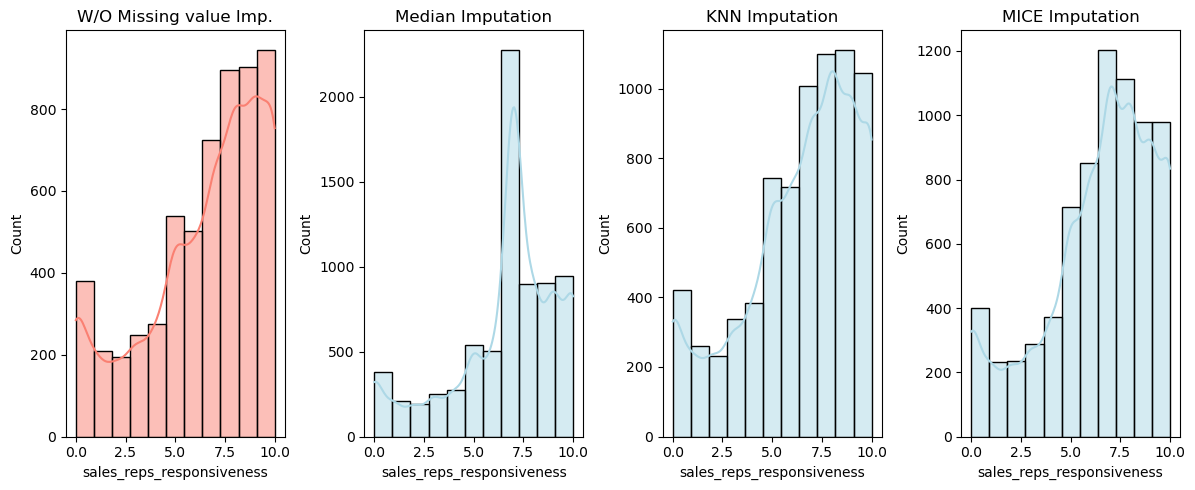

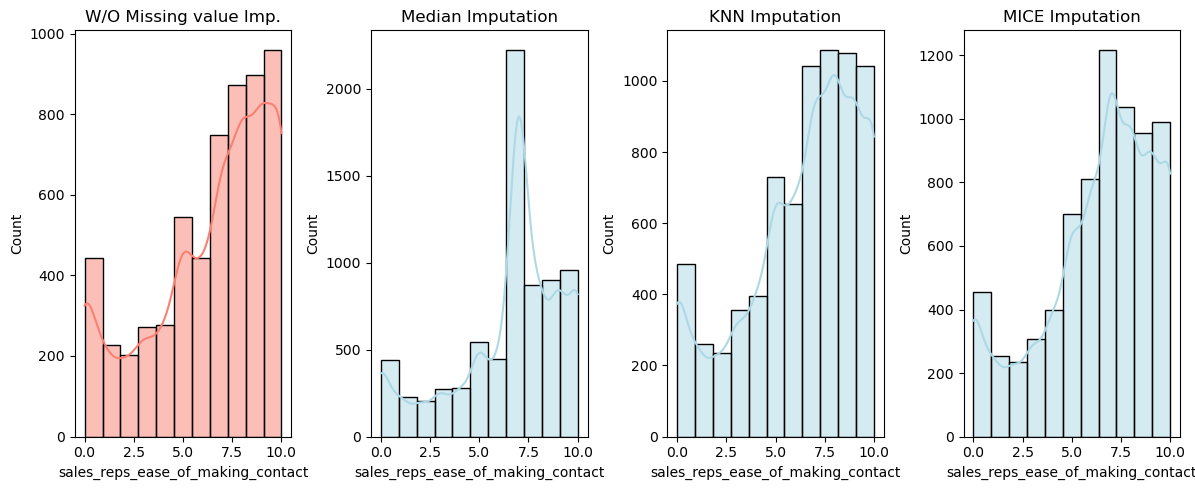

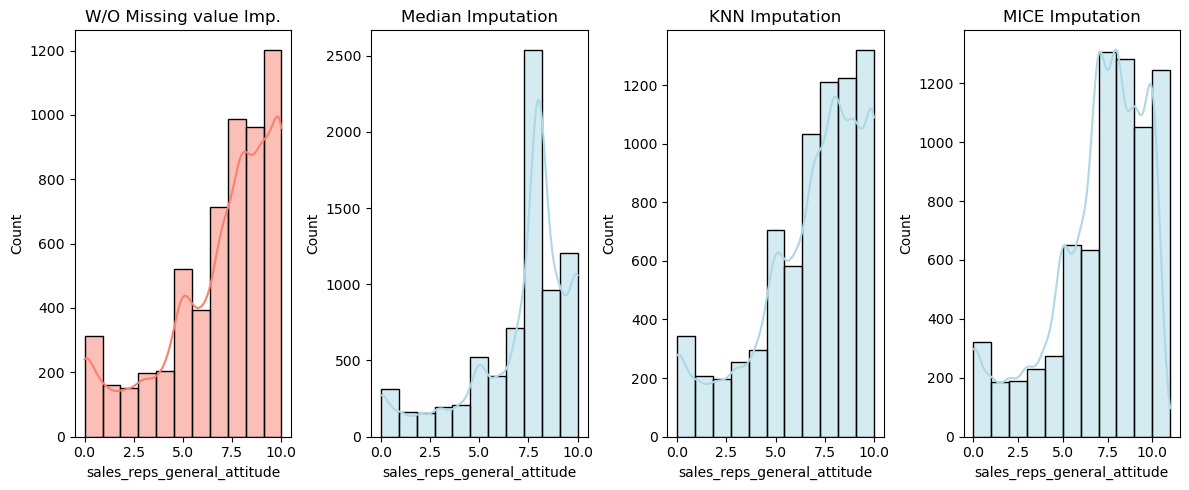

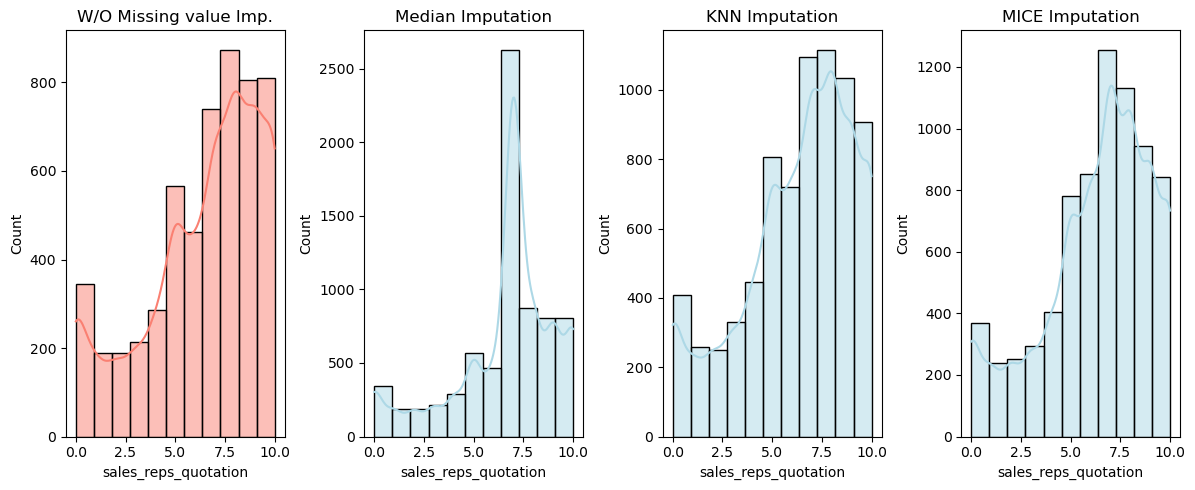

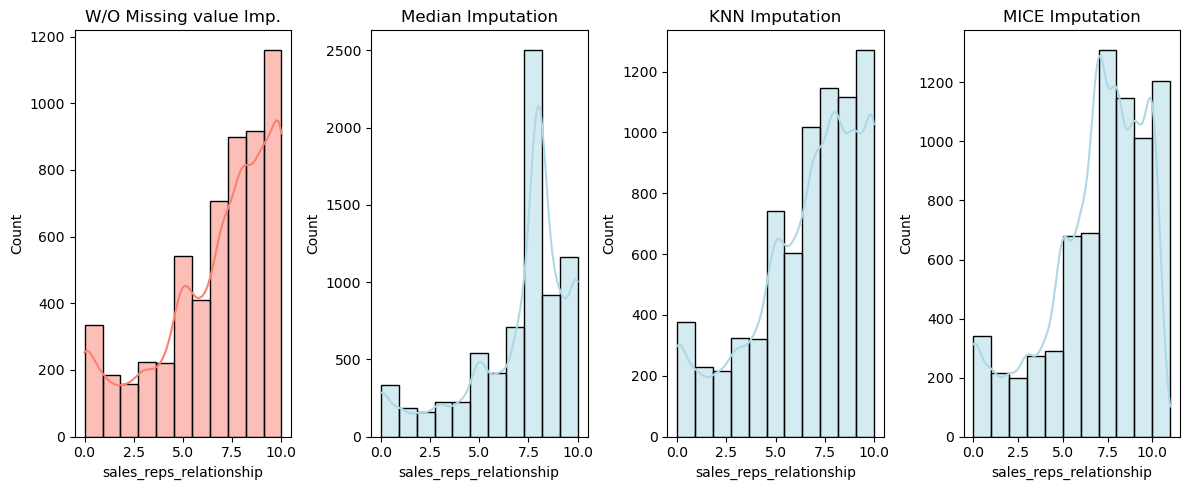

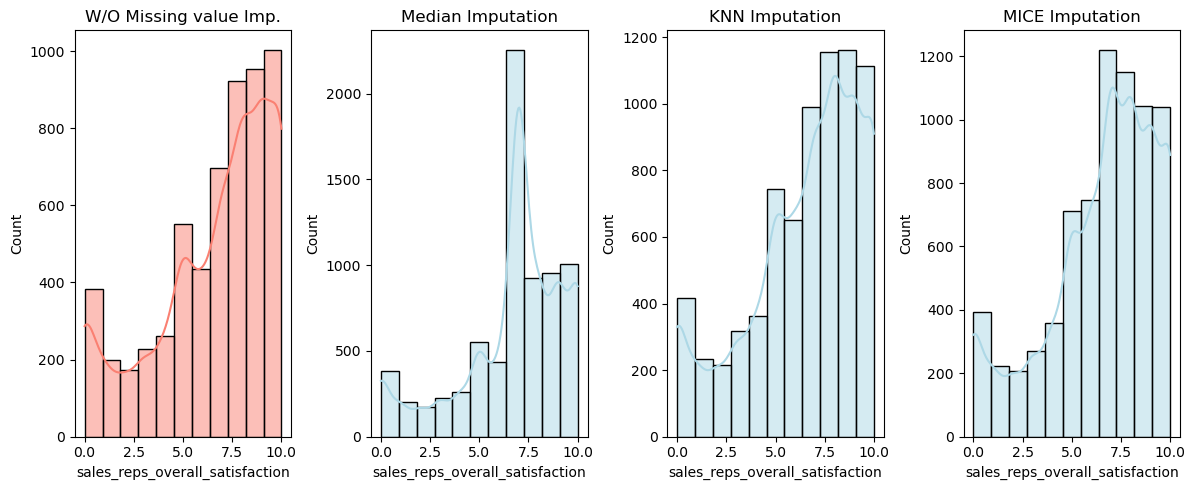

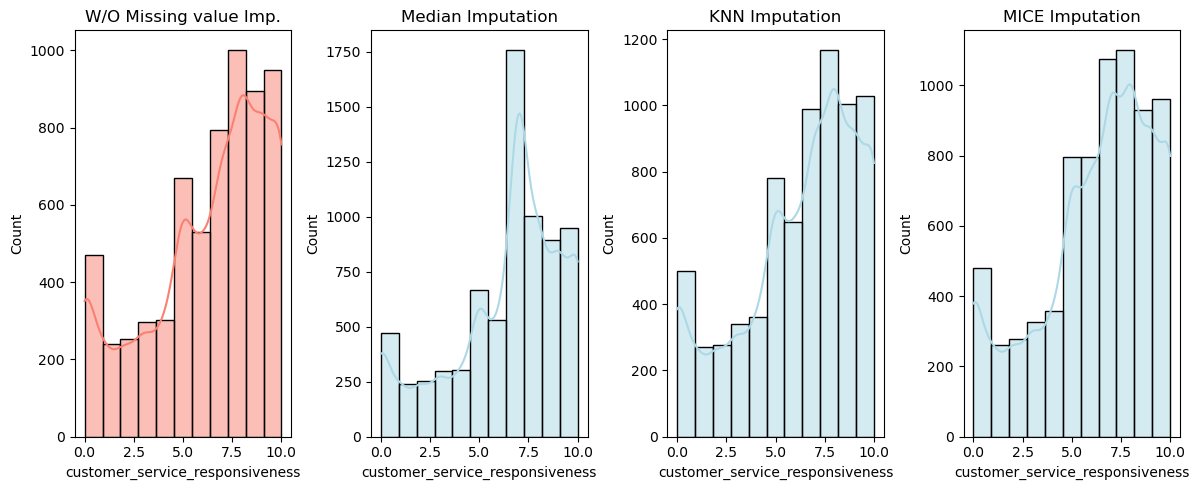

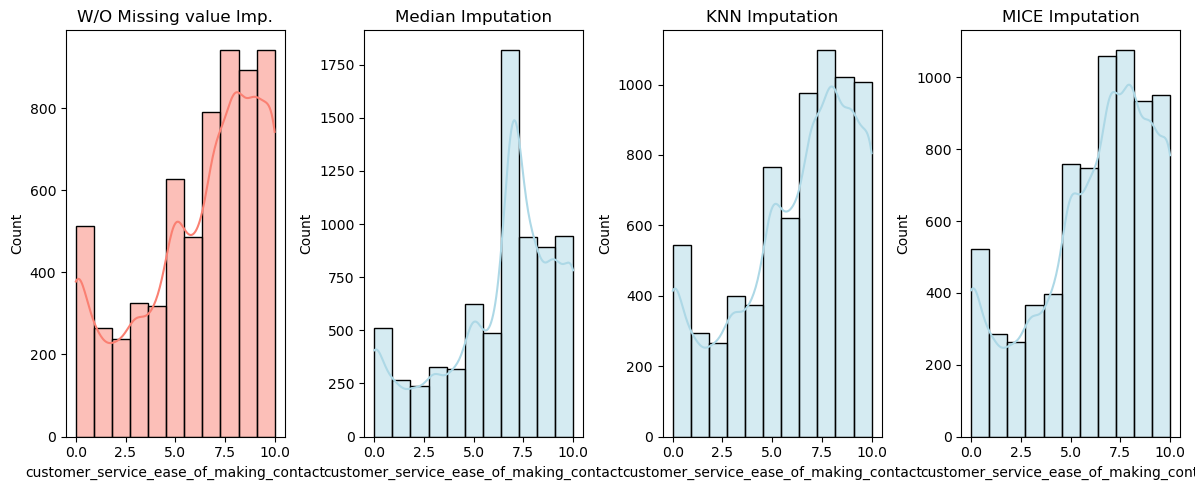

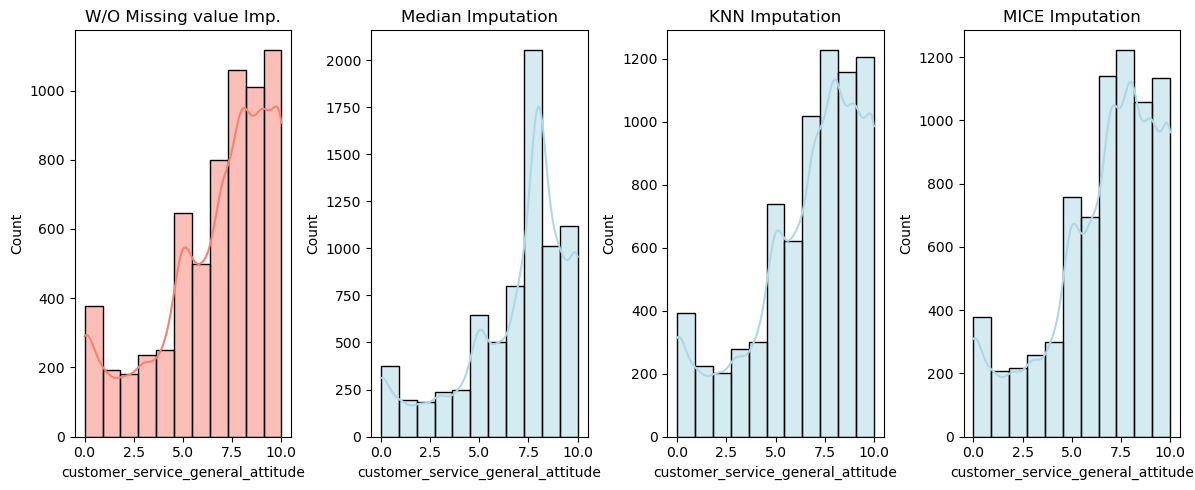

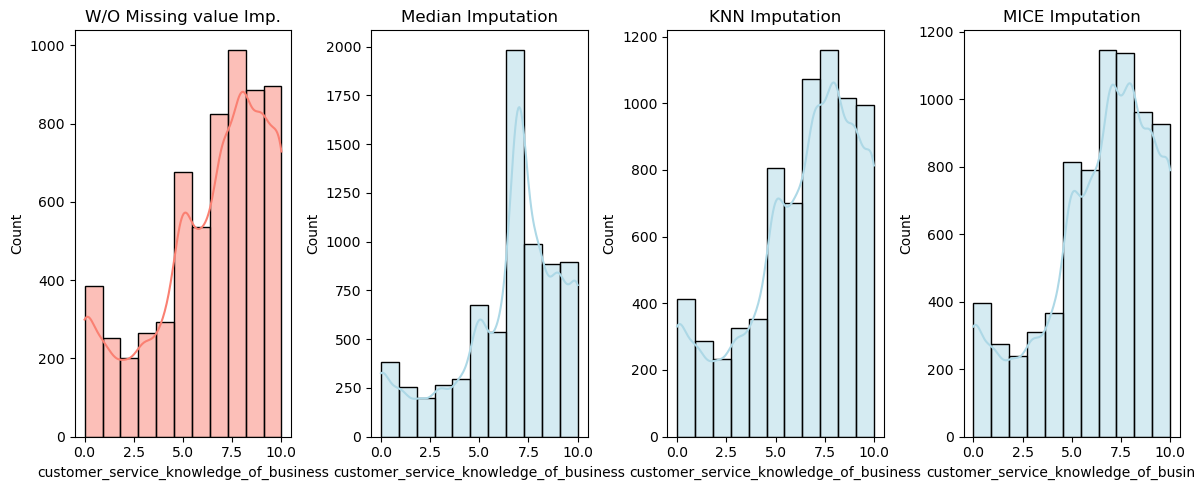

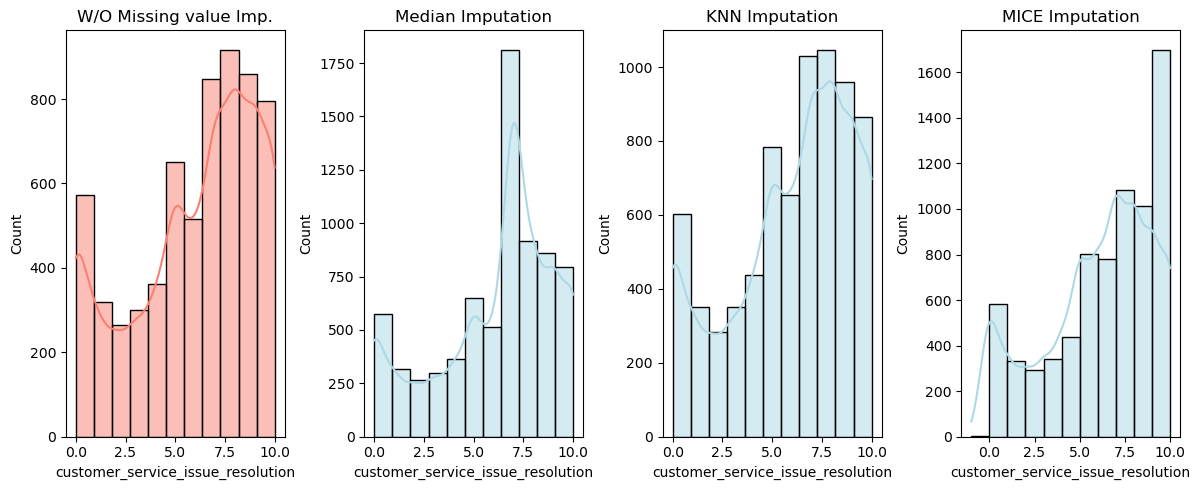

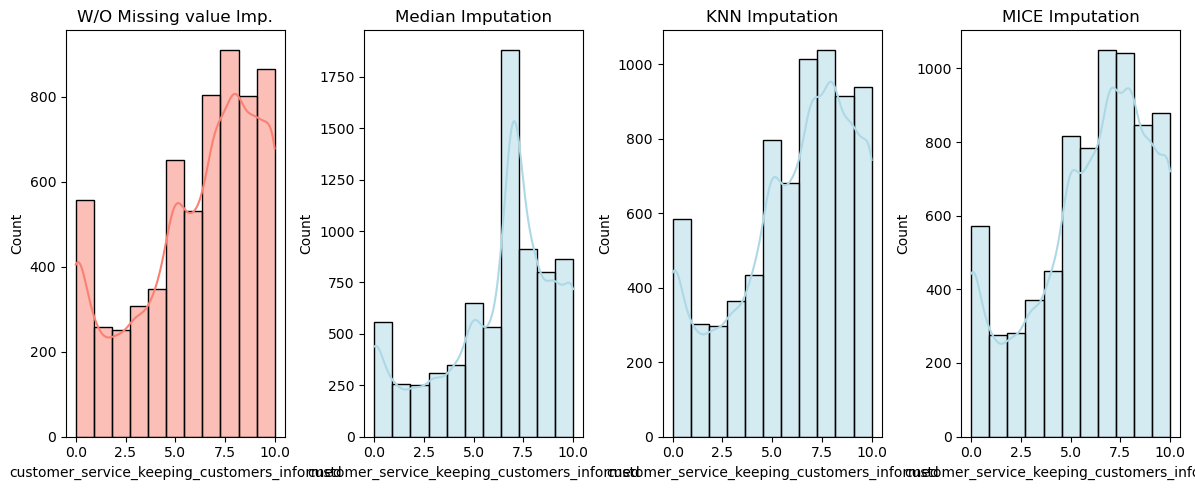

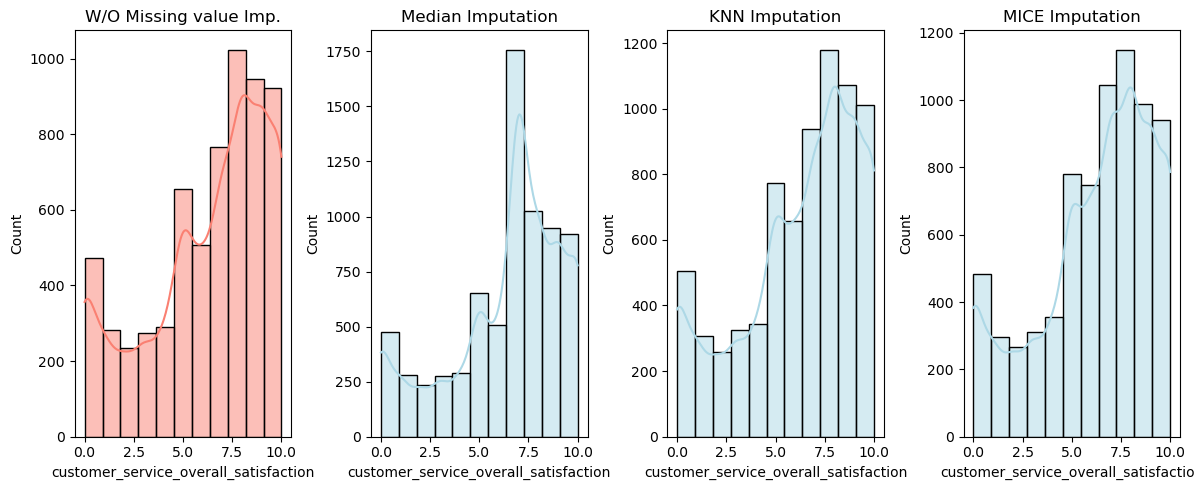

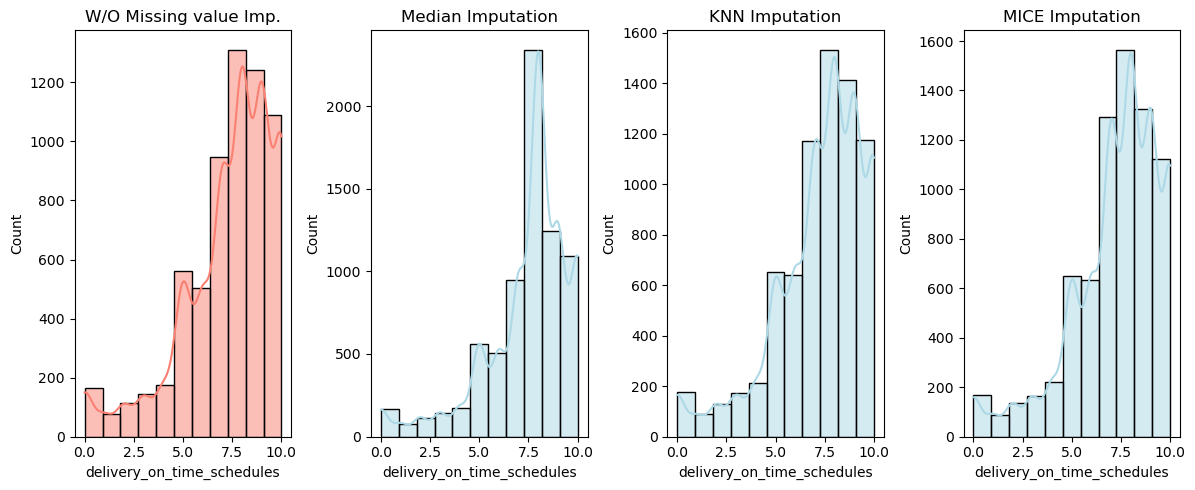

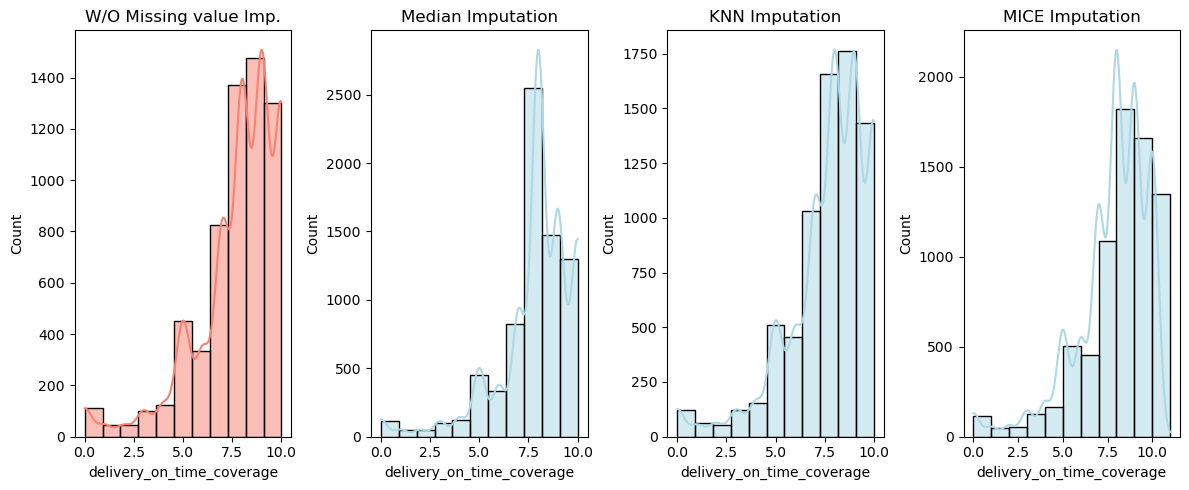

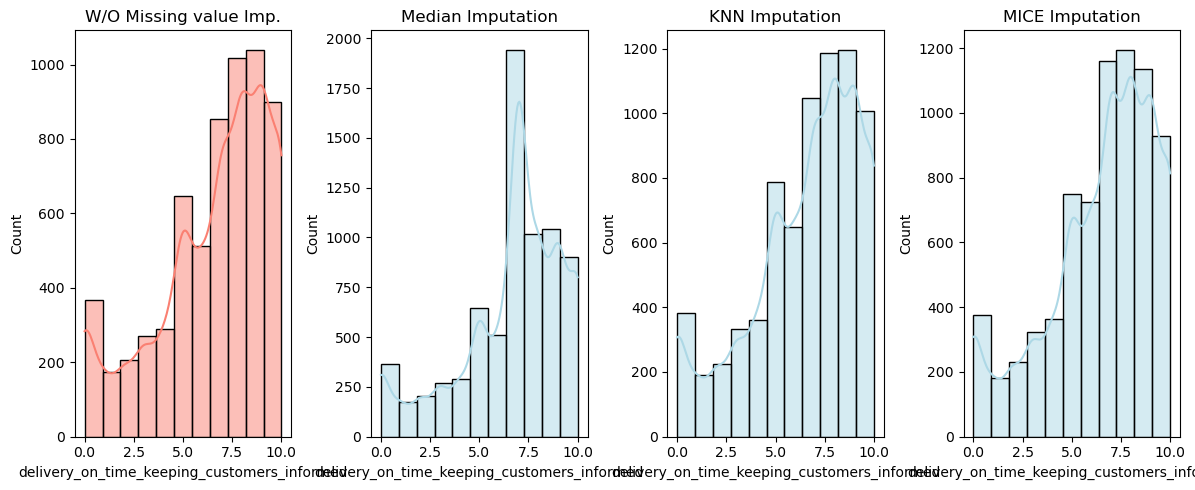

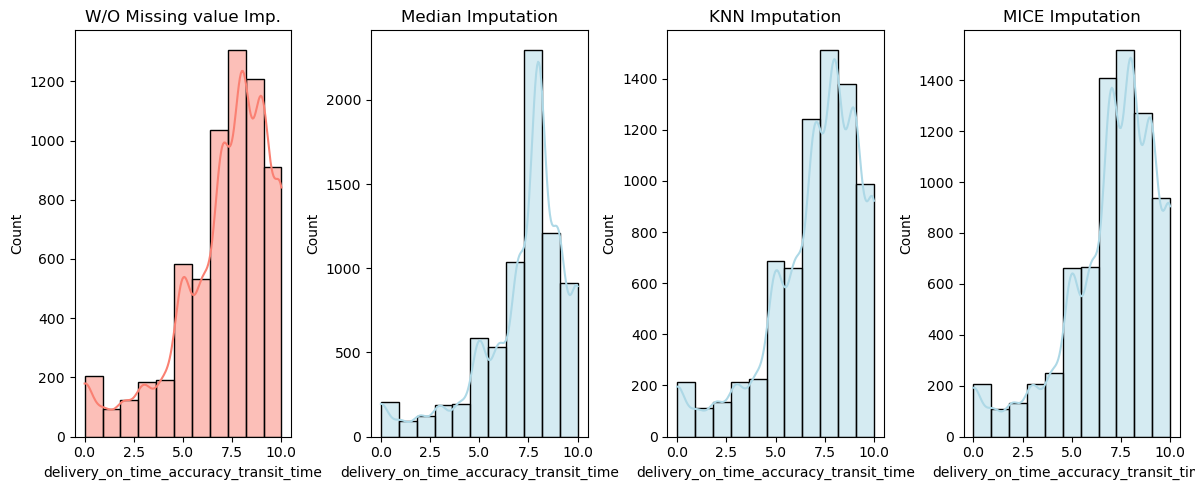

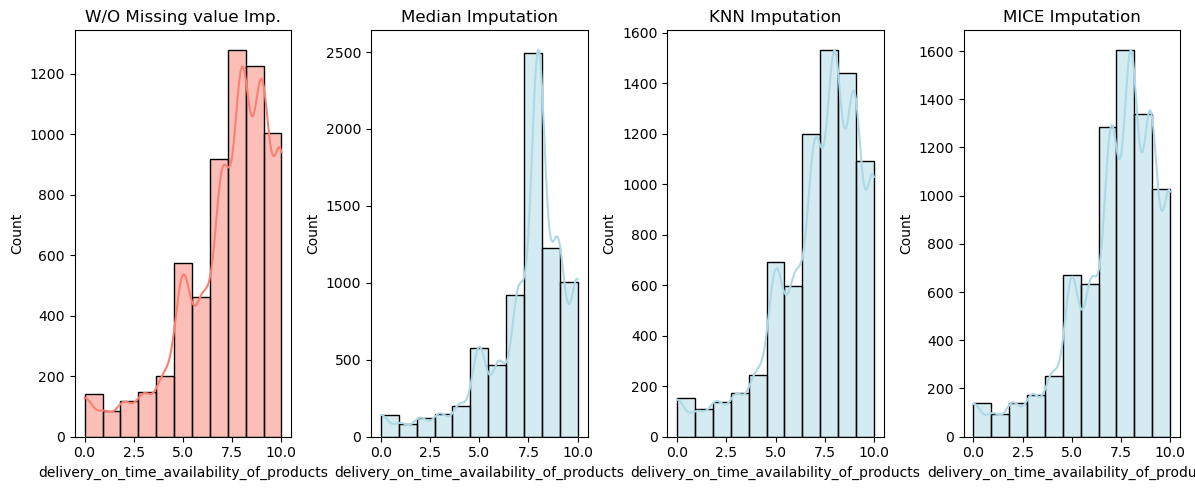

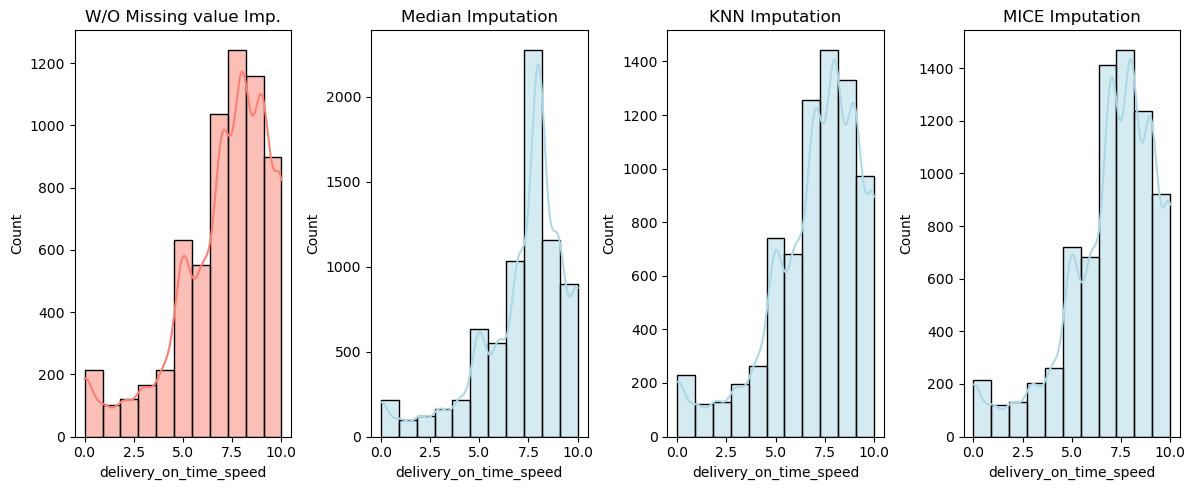

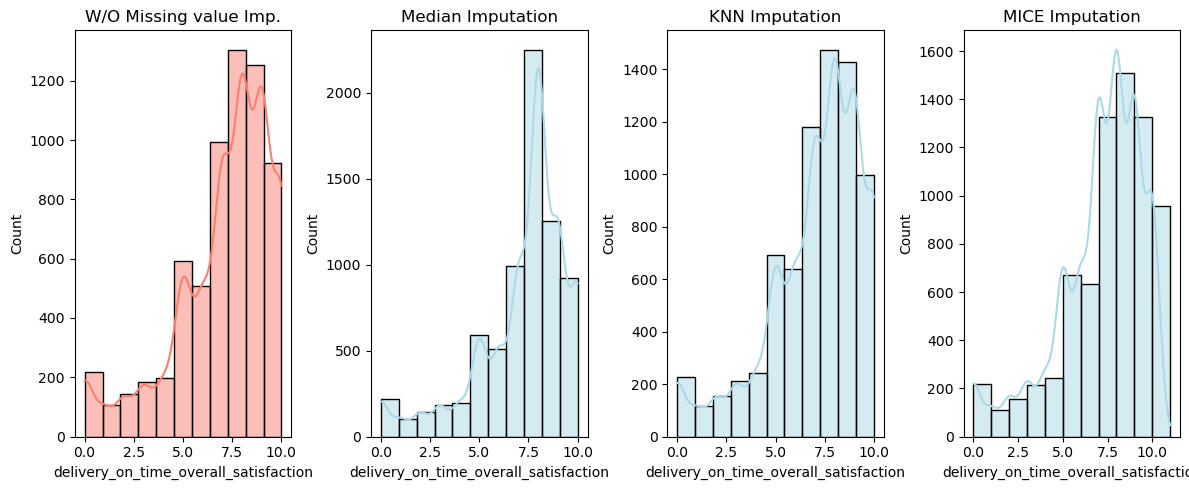

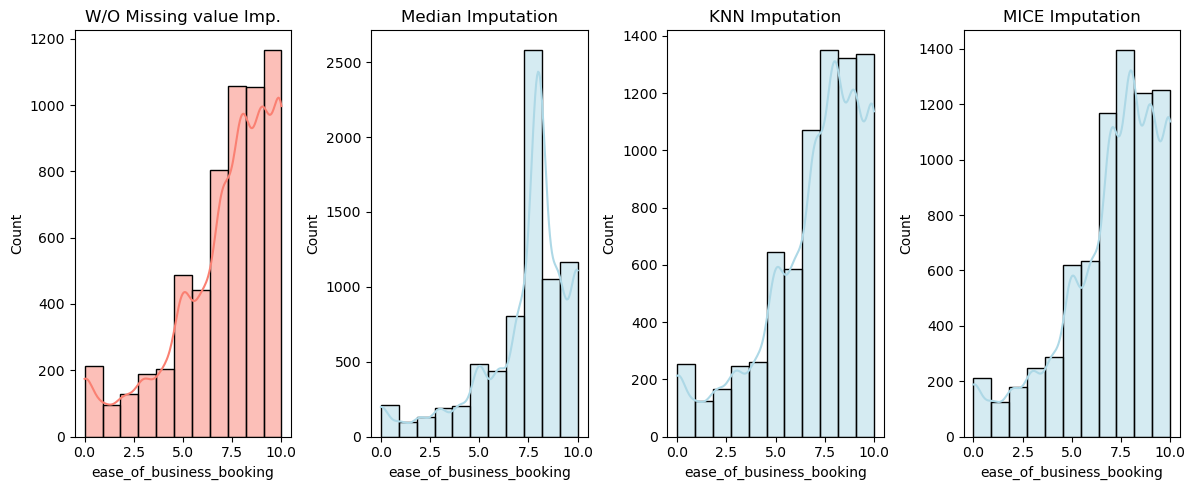

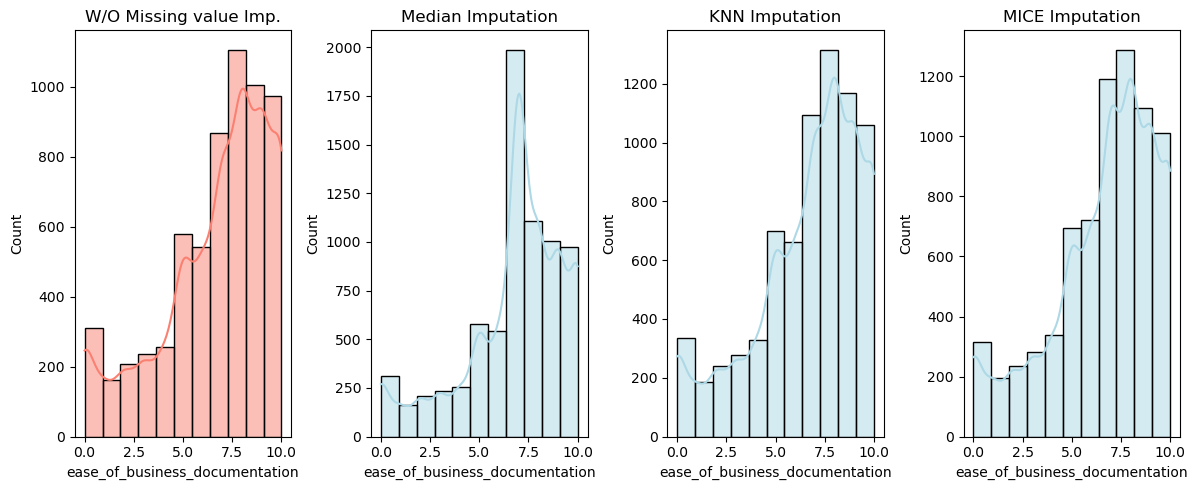

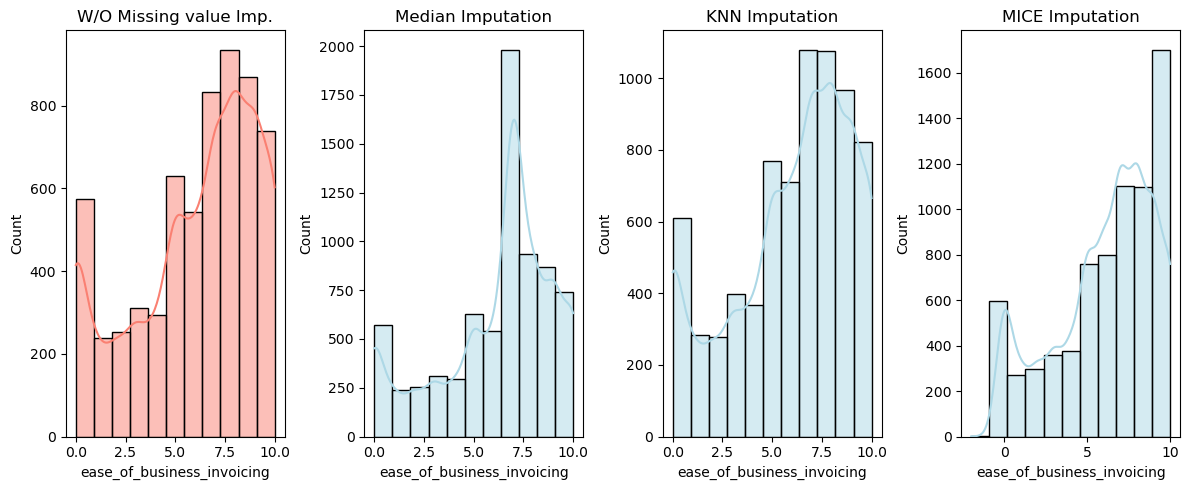

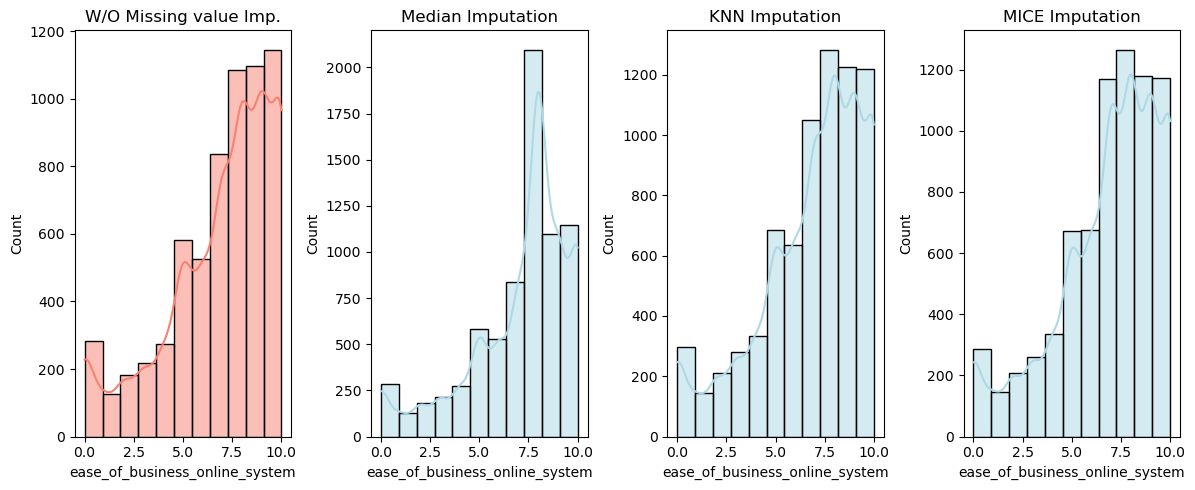

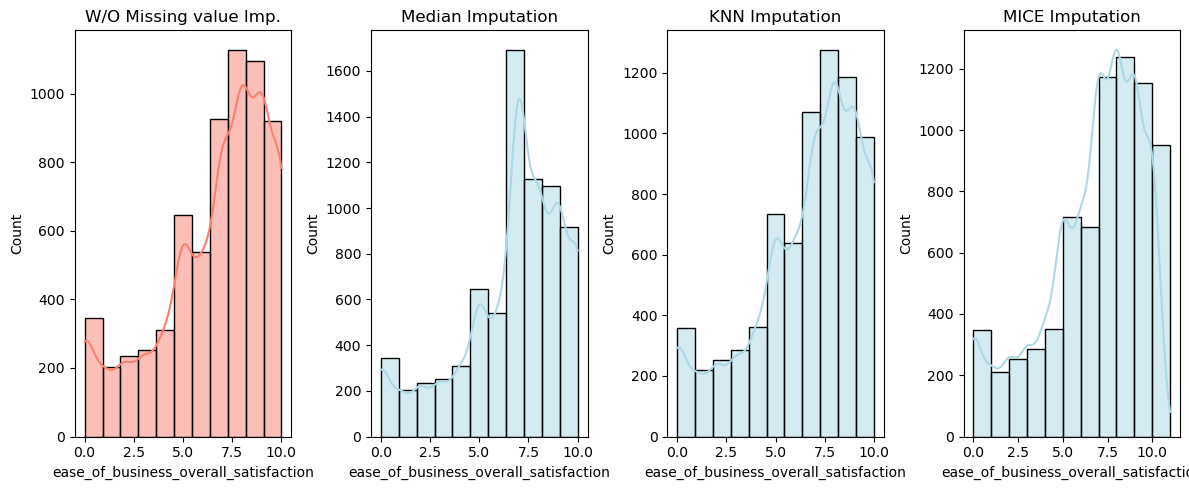

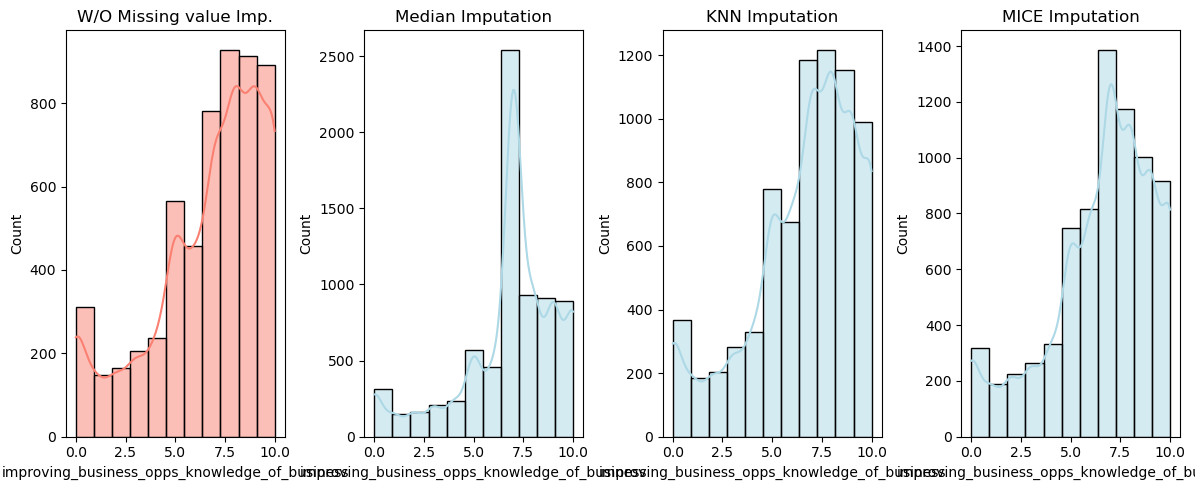

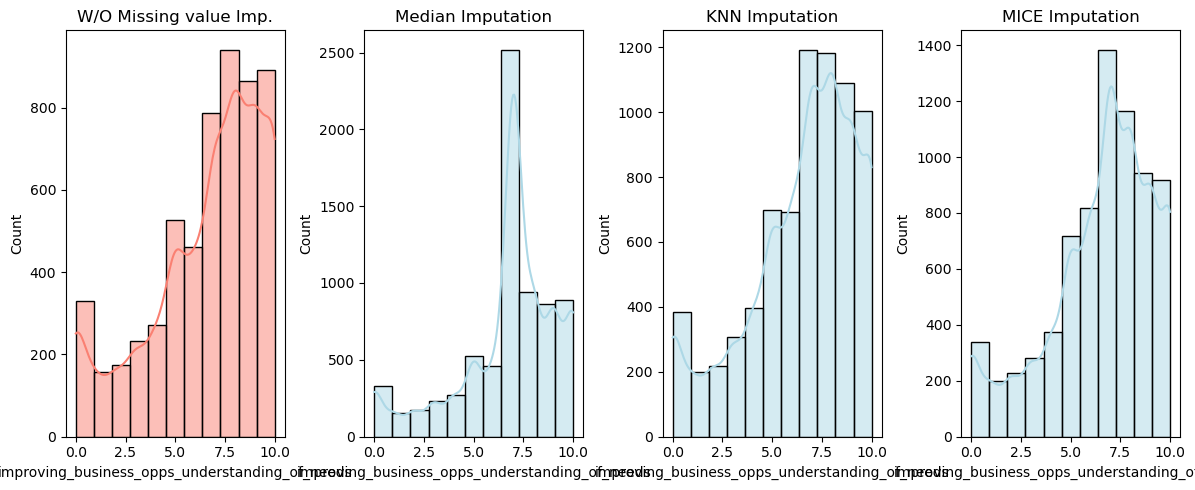

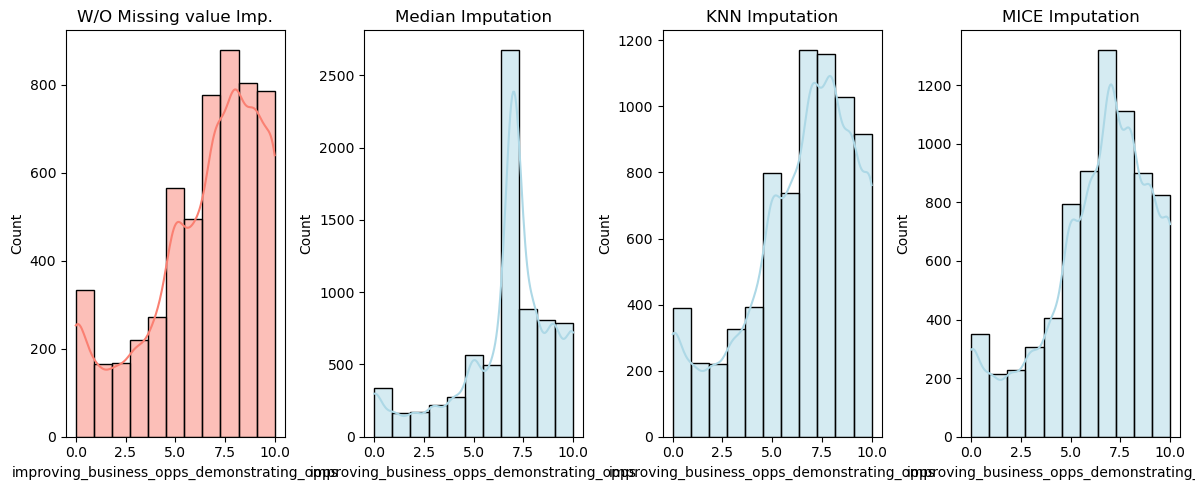

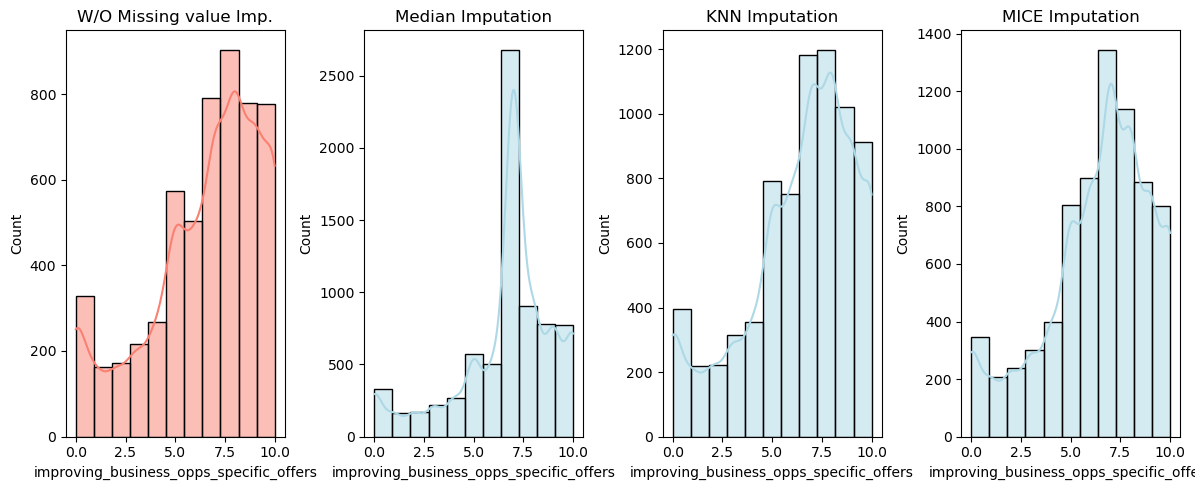

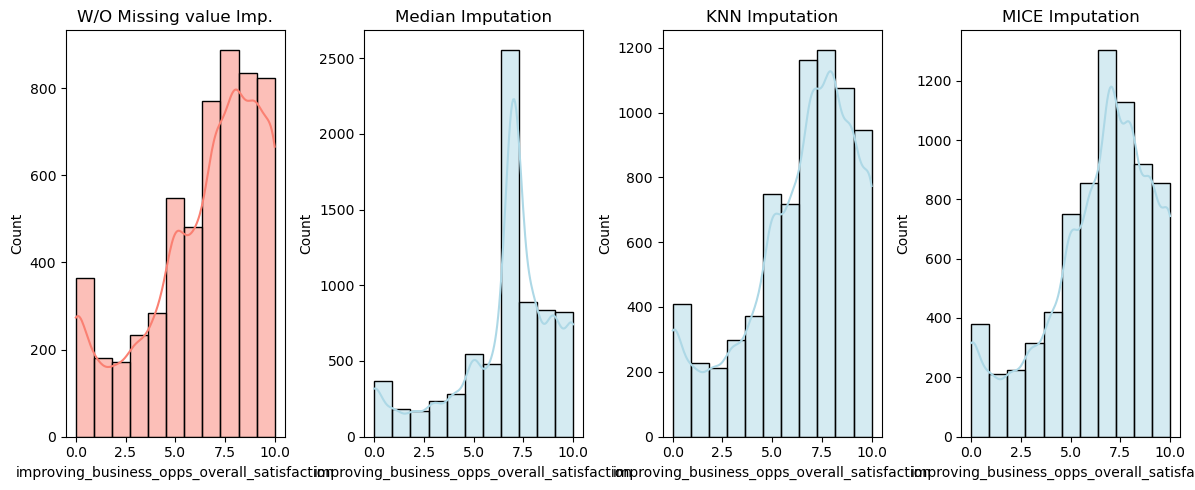

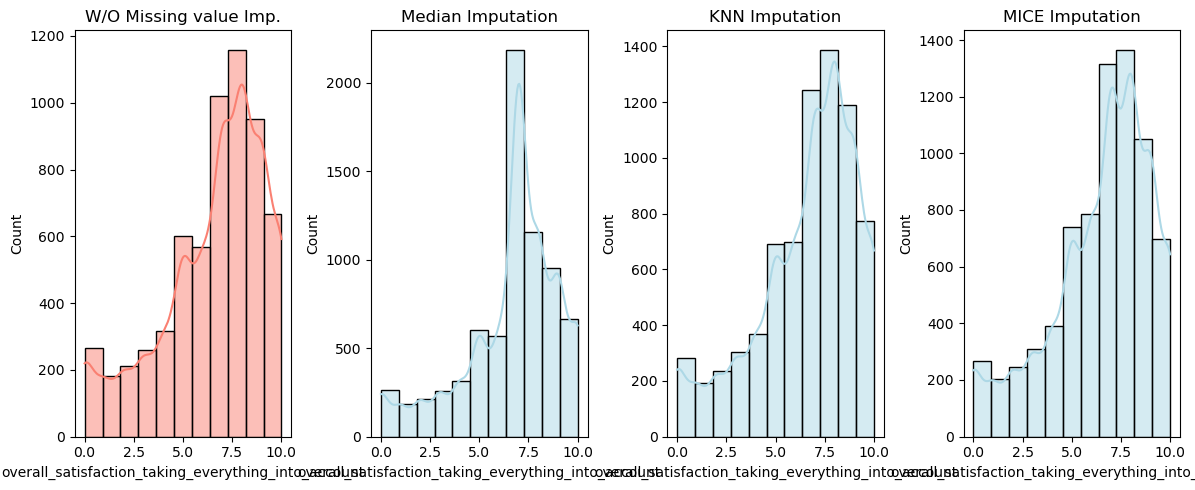

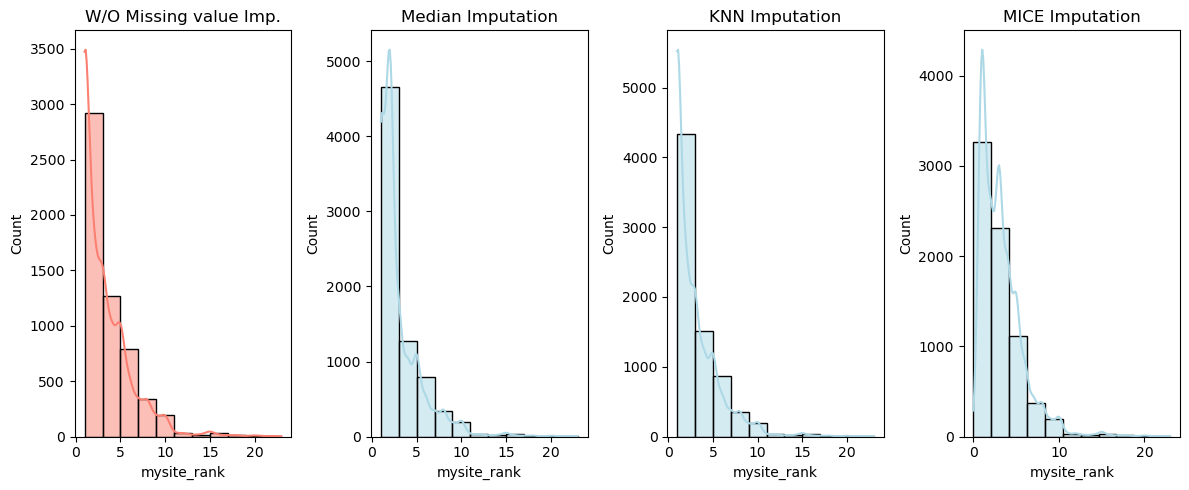

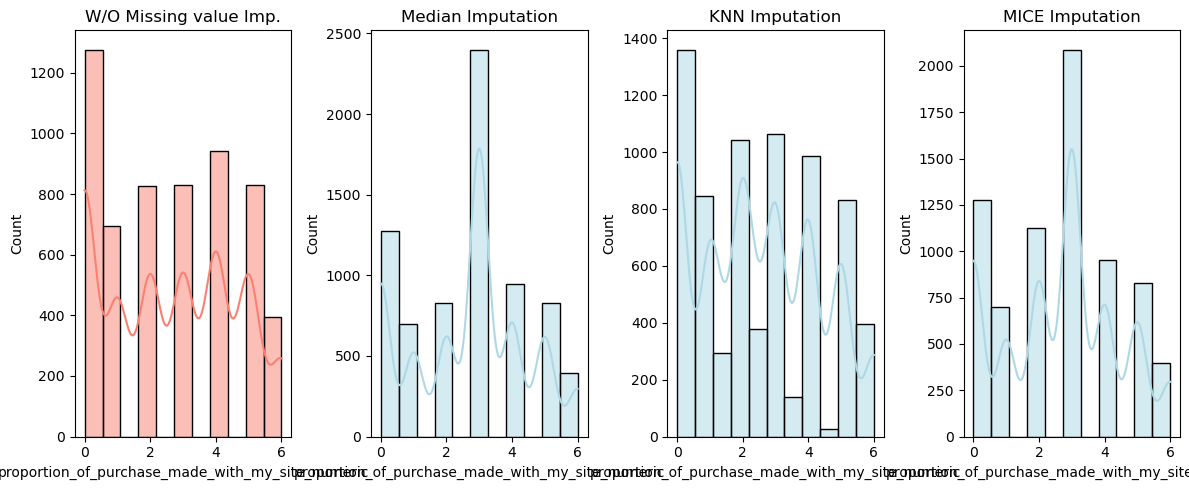

In [14]:
for i in rating_columns:
    # Plot side-by-side histograms
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    # Histogram before removing outliers
    sns.histplot(df1[df1[i]!=99][i], bins=11, kde=True, color="salmon", ax=axes[0])
    axes[0].set_title("W/O Missing value Imp.")

    # Histogram after removing outliers
    sns.histplot(df2[i], bins=11, kde=True, color="lightblue", ax=axes[1])
    axes[1].set_title("Median Imputation")
    
    # Histogram after removing outliers
    sns.histplot(df3[i], bins=11, kde=True, color="lightblue", ax=axes[2])
    axes[2].set_title("KNN Imputation")
    
    # Histogram after removing outliers
    sns.histplot(df4[i], bins=11, kde=True, color="lightblue", ax=axes[3])
    axes[3].set_title("MICE Imputation")

    # Show plots
    plt.tight_layout()
    plt.show()

In [15]:
report(df3.drop('unique_identifier',axis = 1),filename = "Data_Summary_Report_After_Missing_Imp")

Column Name Data Type  \
0             likely_to_recommend_online_site_my_site     int64   
1                               purchased_from_site_a   float64   
2                               purchased_from_site_b   float64   
3                               purchased_from_site_c   float64   
4                               purchased_from_site_d   float64   
..                                                ...       ...   
57            improving_business_opps_specific_offers   float64   
58       improving_business_opps_overall_satisfaction   float64   
59  overall_satisfaction_taking_everything_into_ac...   float64   
60                          #_of_online_sites_used_v1   float64   
61   proportion_of_purchase_made_with_my_site_numeric   float64   

    Missing Values  Missing %  Unique Values      Mean  Median  Min   Max  \
0                0        0.0             11  6.320527     7.0  0.0  10.0   
1                0        0.0              2  0.322970     0.0  0.0   1.0   
2                0        0.0              2  0.568694     1.0  0.0   1.0   
3                0        0.0              2  0.299620     0.0  0.0   1.0   
4                0        0.0              2  0.091773     0.0  0.0   1.0   
..             ...        ...            ...       ...     ...  ...   ...   
57               0        0.0             52  6.442562     7.0  0.0  10.0   
58               0        0.0             52  6.470743     7.0  0.0  10.0   
59               0        0.0             51  6.614494     7.0  0.0  10.0   
60               0        0.0             25  6.108607     5.0  0.0  24.0   
61               0        0.0             30  2.516645     2.4  0.0   6.0   

     Std Dev  Outliers Count  
0   3.022932               0  
1   0.467643               0  
2   0.495292               0  
3   0.458123               0  
4   0.288725             676  
..       ...             ...  
57  2.723089               0  
58  2.758103               0  
59  2.587164               0  
60  5.377900              34  
61  1.800404               0  

[62 rows x 11 columns]

-----------------------------------------------------------------------------------------------------------------------------


Column Name  \
control_count                                                                  control_count   
status                                                                                status   
proportion_of_purchase_made_with_my_site            proportion_of_purchase_made_with_my_site   
future_proportion_of_purchase_made_at_my_site  future_proportion_of_purchase_made_at_my_site   

                                              Data Type  Missing Values  \
control_count                                    object            1853   
status                                           object               0   
proportion_of_purchase_made_with_my_site         object            1568   
future_proportion_of_purchase_made_at_my_site    object            1259   

                                               Missing %  Unique Values  \
control_count                                  25.156123             16   
status                                          0.000000              3   
proportion_of_purchase_made_with_my_site       21.286994              8   
future_proportion_of_purchase_made_at_my_site  17.092045              5   

                                              Most Frequent Value  \
control_count                                               Day 1   
status                                                  COMPLETED   
proportion_of_purchase_made_with_my_site               26% to 50%   
future_proportion_of_purchase_made_at_my_site            Increase   

                                               Most Frequent Count  
control_count                                                 1234  
status                                                        5513  
proportion_of_purchase_made_with_my_site                       943  
future_proportion_of_purchase_made_at_my_site                 1930

### Correlation of features with Target Variable

In [16]:
features = rating_columns + ['#_of_online_sites_used_v1','mysite_rank','proportion_of_purchase_made_with_my_site_numeric'] 
ltr_column = 'likely_to_recommend_online_site_my_site'

# Compute correlation of PCA components with LTR
ltr_correlation = df3[features + [ltr_column]].corr()[ltr_column].drop(ltr_column)
# Print correlation values
print(round(ltr_correlation,2))

sales_reps_responsiveness                              0.64
sales_reps_ease_of_making_contact                      0.62
sales_reps_general_attitude                            0.61
sales_reps_quotation                                   0.63
sales_reps_relationship                                0.61
sales_reps_overall_satisfaction                        0.65
customer_service_responsiveness                        0.69
customer_service_ease_of_making_contact                0.65
customer_service_general_attitude                      0.66
customer_service_knowledge_of_business                 0.67
customer_service_issue_resolution                      0.71
customer_service_keeping_customers_informed            0.64
customer_service_overall_satisfaction                  0.70
delivery_on_time_schedules                             0.55
delivery_on_time_coverage                              0.51
delivery_on_time_keeping_customers_informed            0.60
delivery_on_time_accuracy_transit_time  

### Check Correlation within independent variables

feature        VIF
0                           sales_reps_responsiveness  57.270442
1                   sales_reps_ease_of_making_contact  42.867543
2                         sales_reps_general_attitude  63.280750
3                                sales_reps_quotation  32.714228
4                             sales_reps_relationship  53.276919
5                     sales_reps_overall_satisfaction  88.568693
6                     customer_service_responsiveness  48.740944
7             customer_service_ease_of_making_contact  28.139154
8                   customer_service_general_attitude  48.220449
9              customer_service_knowledge_of_business  37.508076
10                  customer_service_issue_resolution  32.346909
11        customer_service_keeping_customers_informed  20.233078
12              customer_service_overall_satisfaction  66.675895
13                         delivery_on_time_schedules  43.633396
14                          delivery_on_time_coverage  38.174729
15        delivery_on_time_keeping_customers_informed  22.043339
16             delivery_on_time_accuracy_transit_time  43.433182
17          delivery_on_time_availability_of_products  30.243965
18                             delivery_on_time_speed  39.191478
19              delivery_on_time_overall_satisfaction  56.327979
20                           ease_of_business_booking  35.702965
21                     ease_of_business_documentation  31.956272
22                         ease_of_business_invoicing  15.200053
23                     ease_of_business_online_system  25.200921
24              ease_of_business_overall_satisfaction  48.056707
25      improving_business_opps_knowledge_of_business  71.665689
26     improving_business_opps_understanding_of_needs  80.941306
27         improving_business_opps_demonstrating_opps  74.323781
28            improving_business_opps_specific_offers  67.448715
29       improving_business_opps_overall_satisfaction  83.813777
30  overall_satisfaction_taking_everything_into_ac...  47.084825
31                                        mysite_rank   2.178206
32   proportion_of_purchase_made_with_my_site_numeric   3.042523

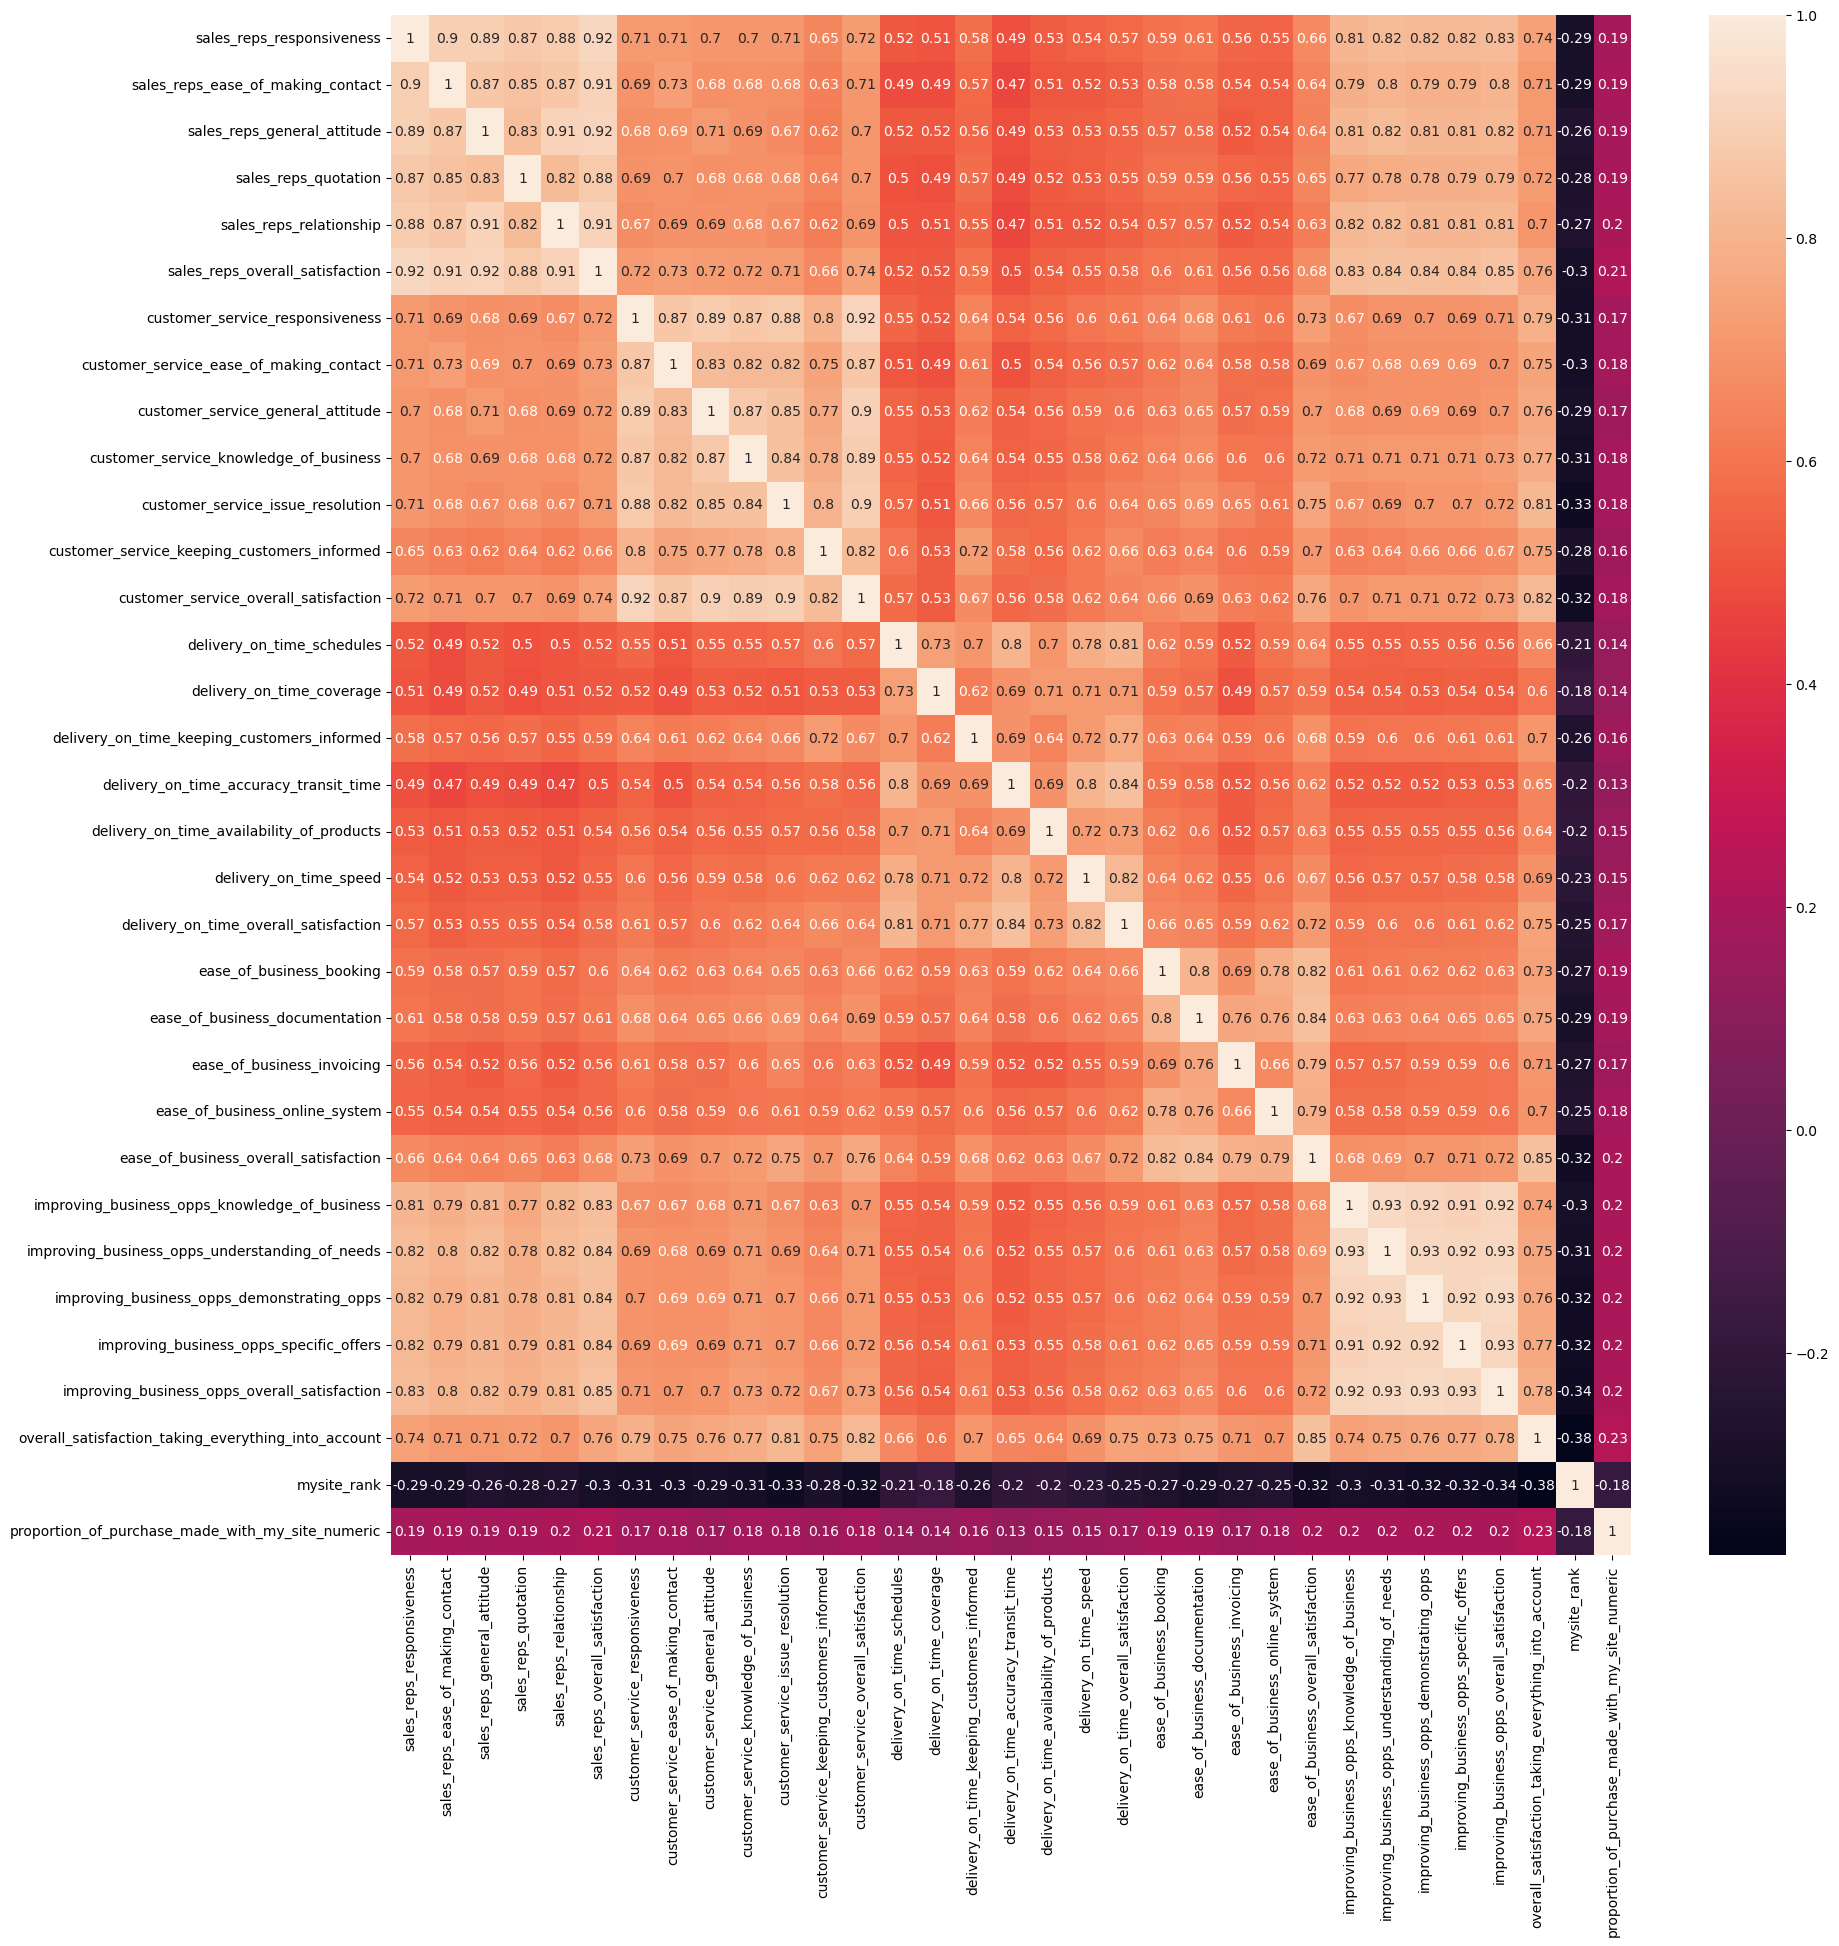

In [17]:
feature_col = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account','mysite_rank','proportion_of_purchase_made_with_my_site_numeric']

plt.figure(figsize=(20, 20))
sns.heatmap(df3[feature_col].corr(),annot=True)
vif_data = pd.DataFrame()
vif_data["feature"] = df3[feature_col].columns
vif_data["VIF"] = [variance_inflation_factor(df3[feature_col].values, i)
                          for i in range(len(df3[feature_col].columns))]

display(pd.DataFrame(vif_data))

### Target Definition

In [18]:
def categorize_nps(score):
    if score >= 7:
        return 1  # Promoters (9-10) & Passives (7-8)
    else:
        return 0  # Detractors

df3["LTR_Category"] = df3["likely_to_recommend_online_site_my_site"].apply(categorize_nps)

In [19]:
df3["LTR_Category"].value_counts(normalize = True)*100

1    55.41678
0    44.58322
Name: LTR_Category, dtype: float64

### Principal Component Analysis on Thematic Metrics

In [20]:
# Standardize and apply PCA to each category
scaler = StandardScaler()
pca = PCA(n_components=1)

def apply_pca(features):
    if features:
        scaled = scaler.fit_transform(df3[features])
        return pca.fit_transform(scaled).flatten()
    return np.zeros(len(df3))

df3["Sales_PC"] = apply_pca(sales_reps[:-1])
df3["Customer_Service_PC"] = apply_pca(customer_service[:-1])
df3["Ease_of_Business_PC"] = apply_pca(ease_of_business[:-1])
df3["Delivery_PC"] = apply_pca(delivery_on_time[:-1])
df3["Improving_Business_Opps_PC"] = apply_pca(improving_business_opps[:-1])

feature       VIF
0                               Customer_Service_PC  3.256166
1                               Ease_of_Business_PC  3.037583
2                                       Delivery_PC  2.567286
3                        Improving_Business_Opps_PC  2.692351
4                                       mysite_rank  1.613438
5  proportion_of_purchase_made_with_my_site_numeric  1.551076

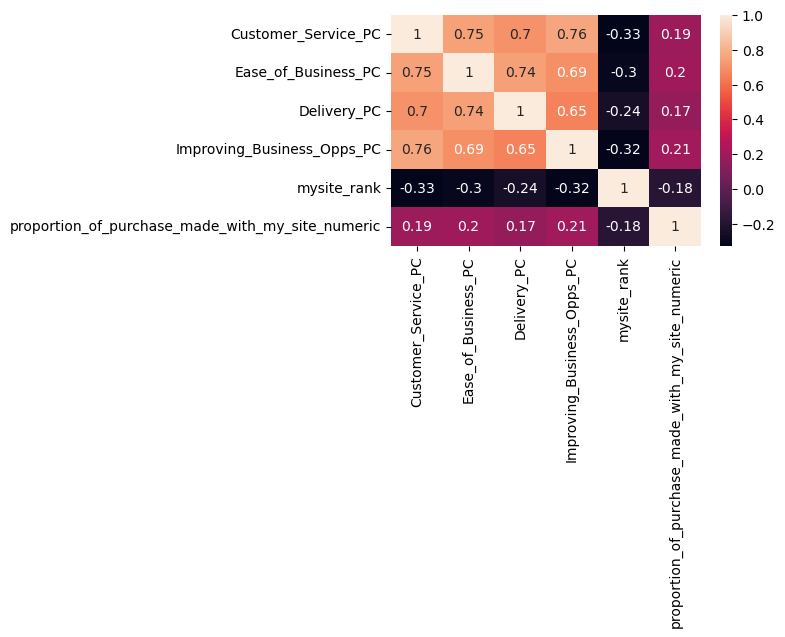

In [21]:
feature_col = ['Customer_Service_PC','Ease_of_Business_PC','Delivery_PC','Improving_Business_Opps_PC','mysite_rank','proportion_of_purchase_made_with_my_site_numeric']
from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.figure(figsize=(5,3))
sns.heatmap(df3[feature_col].corr(),annot=True)
vif_data = pd.DataFrame()
vif_data["feature"] = df3[feature_col].columns
vif_data["VIF"] = [variance_inflation_factor(df3[feature_col].values, i)
                          for i in range(len(df3[feature_col].columns))]

display(pd.DataFrame(vif_data))

In [22]:
list = [sales_reps,customer_service,ease_of_business,delivery_on_time,improving_business_opps]
for i in list:
    pc_df = df3[i[:-1]].dropna()

    # Standardize data (PCA requires standardization)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pc_df)

    # Apply PCA
    pca = PCA(n_components=1)  
    pca_transformed = pca.fit_transform(scaled_data)
    
    explained_variance = pca.explained_variance_ratio_
    # Extract PCA loadings (importance of each original feature in each PC)
    pca_loadings = pd.DataFrame(pca.components_.T, index=i[:-1], columns=['PC1'])

    # Print the top contributing features for each PC
    print("Variation Explained by PC1:", round(explained_variance[0],2)*100,"%")
    print("\nTop Contributing Features to Each PC:")
    print(pca_loadings.abs().sort_values(by="PC1", ascending=False).head(10))
    print("---------------------------------------------------------------------------------------------")

Variation Explained by PC1: 90.0 %

Top Contributing Features to Each PC:
                                        PC1
sales_reps_responsiveness          0.453921
sales_reps_general_attitude        0.449596
sales_reps_relationship            0.447812
sales_reps_ease_of_making_contact  0.447505
sales_reps_quotation               0.437061
---------------------------------------------------------------------------------------------
Variation Explained by PC1: 86.0 %

Top Contributing Features to Each PC:
                                                  PC1
customer_service_responsiveness              0.420877
customer_service_general_attitude            0.413316
customer_service_knowledge_of_business       0.411798
customer_service_issue_resolution            0.411798
customer_service_ease_of_making_contact      0.403979
customer_service_keeping_customers_informed  0.386884
---------------------------------------------------------------------------------------------
Variation Explained by

### Classification Approach

## Feature Scaling and Train Test Split

In [23]:
X = df3[["Customer_Service_PC", "Ease_of_Business_PC", "Delivery_PC", 
        "Improving_Business_Opps_PC", 'mysite_rank','proportion_of_purchase_made_with_my_site_numeric']]
y = df3[["LTR_Category"]]

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add constant for intercept
X_scaled = sm.add_constant(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### Cross Validation to get best parameters for Logistic Regression

In [24]:
# # Define hyperparameter grid
# param_grid = {
#     'C': np.logspace(-4, 4, 20),  # Regularization strength
#     'solver': ['liblinear', 'lbfgs', 'saga'],  # Optimizers
#     'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization types
#     'max_iter': [100, 500, 1000]  # Maximum iterations
# }

# # Initialize logistic regression model
# log_reg = LogisticRegression()

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=log_reg,
#     param_distributions=param_grid,
#     n_iter=50,  # Number of random samples
#     cv=20,  # 5-fold cross-validation
#     scoring='f1',  # Metric to optimize
#     random_state=42,
#     n_jobs=-1  # Use all processors
# )

# # Fit the random search model
# random_search.fit(X_train_scaled, y_train_scaled.values.ravel())

# # Print the best parameters and accuracy score
# print("Best Parameters:", random_search.best_params_)
# print("Best Cross-Validation Score:", random_search.best_score_)

Optimization terminated successfully.
         Current function value: 0.402952
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           LTR_Category   No. Observations:                 5892
Model:                          Logit   Df Residuals:                     5885
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.4137
Time:                        10:07:17   Log-Likelihood:                -2374.2
converged:                       True   LL-Null:                       -4049.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -6.7169      0.221    -30.439      0.000      -7.149      -6.284
Customer_Service_PC                                  3.0166      0.230     13.091      0.000       2.565       3.468
Ease_of_Business_PC                                  3.3315      0.261     12.765      0.000       2.820       3.843
Delivery_PC                                          2.3354      0.302      7.739      0.000       1.744       2.927
Improving_Business_Opps_PC                           1.5790      0.221      7.149      0.000       1.146       2.012
mysite_rank                                         -2.9110      0.380     -7.656      0.000      -3.656      -2.166
proportion_of_purchase_made_with_my_site_numeric     0.7230      0.126      5.721      0.000       0.475       0.971
====================================================================================================================
"""

Results on Trainng Data :
Confusion Matrix:



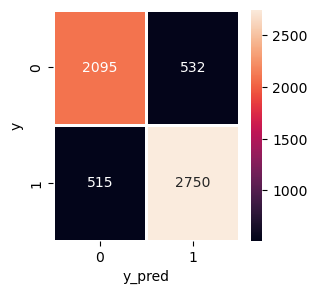

ROC Curve:



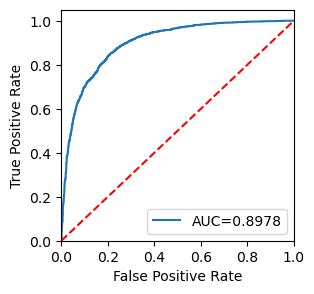

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2627
           1       0.84      0.84      0.84      3265

    accuracy                           0.82      5892
   macro avg       0.82      0.82      0.82      5892
weighted avg       0.82      0.82      0.82      5892

Precision Score for Positive Class : 0.8379
Recall Score for Positive Class: 0.8423
f1 Score for Positive Class: 0.8401
Accuracy Score for Positive Class: 0.8223
Results on Validation Data :
Confusion Matrix:



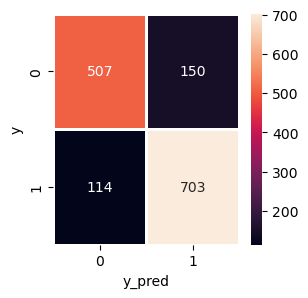

ROC Curve:



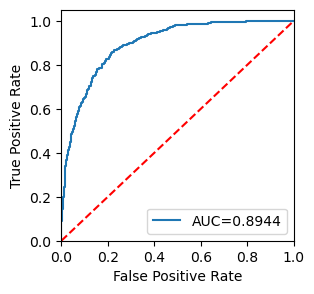

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       657
           1       0.82      0.86      0.84       817

    accuracy                           0.82      1474
   macro avg       0.82      0.82      0.82      1474
weighted avg       0.82      0.82      0.82      1474

Precision Score for Positive Class : 0.8242
Recall Score for Positive Class: 0.8605
f1 Score for Positive Class: 0.8419
Accuracy Score for Positive Class: 0.8209


In [25]:
log_reg = sm.Logit(y_train_scaled, X_train_scaled).fit()
display(log_reg.summary())

logisticRegr = LogisticRegression(solver = 'saga', penalty = 'l2', max_iter = 500, C = 0.615848211066026)
logisticRegr.fit(X_train_scaled, y_train_scaled)
cutoff =0.55
y_pred_proba_train = logisticRegr.predict_proba(X_train_scaled)[:,1]
y_pred_train = np.where(y_pred_proba_train> cutoff,1,0)

print ('Results on Trainng Data :')
model_evaluation_report(y_train_scaled,y_pred_train,y_pred_proba_train)

y_pred_proba_test = logisticRegr.predict_proba(X_test_scaled)[:,1]
y_pred_test = np.where(y_pred_proba_test> cutoff,1,0)

print ('Results on Validation Data :')
model_evaluation_report(y_test_scaled,y_pred_test,y_pred_proba_test)

### Check Assusmptions of Logistic Regression

Optimization terminated successfully.
         Current function value: 0.403160
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           LTR_Category   No. Observations:                 7366
Model:                          Logit   Df Residuals:                     7359
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.4134
Time:                        10:07:18   Log-Likelihood:                -2969.7
converged:                       True   LL-Null:                       -5062.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                           

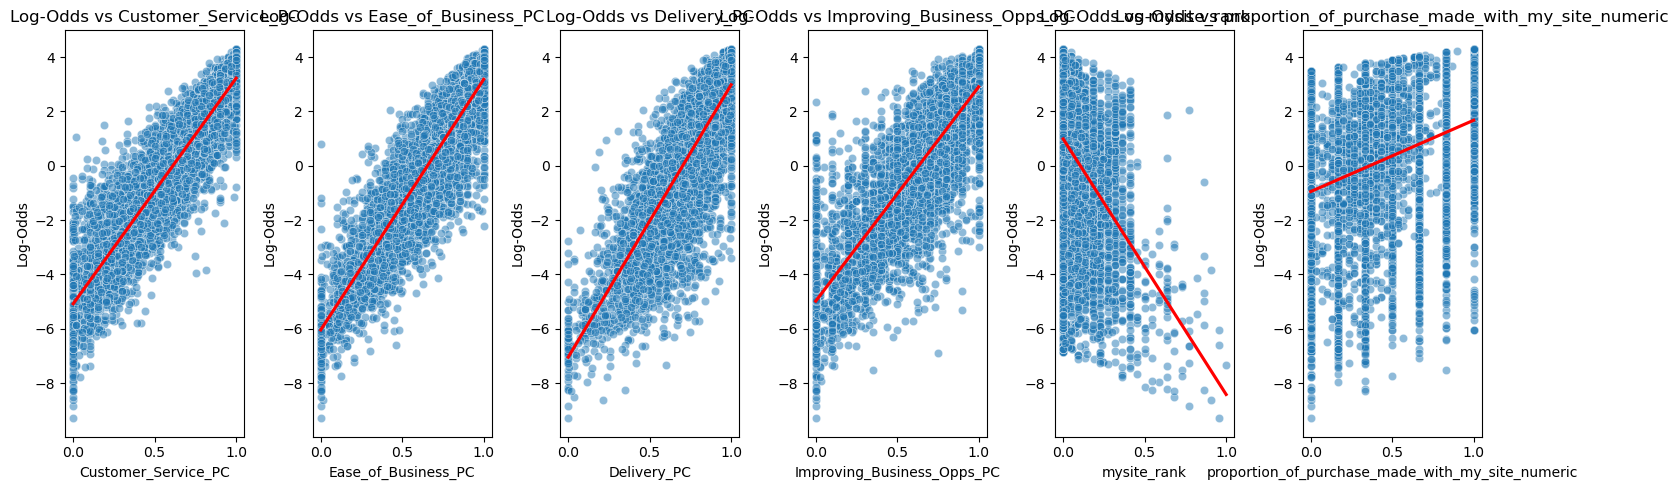

Optimization terminated successfully.
         Current function value: 0.401220
         Iterations 8

Box-Tidwell Test Results:
                           Logit Regression Results                           
Dep. Variable:           LTR_Category   No. Observations:                 7366
Model:                          Logit   Df Residuals:                     7353
Method:                           MLE   Df Model:                           12
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.4162
Time:                        10:07:20   Log-Likelihood:                -2955.4
converged:                       True   LL-Null:                       -5062.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------

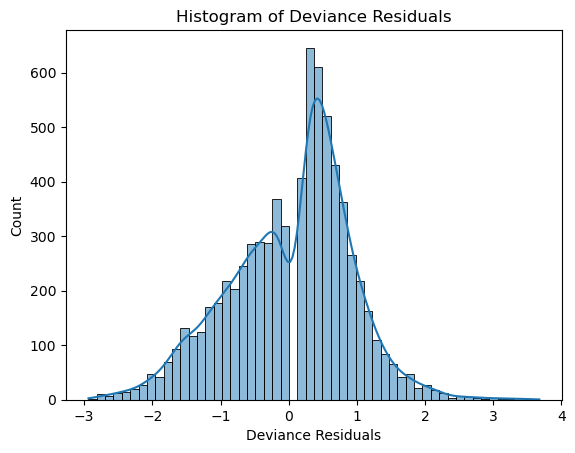

In [26]:
# Fit logistic regression model
model = sm.Logit(y, X_scaled).fit()
print(model.summary())

# Get log-odds (linear predictor)
log_odds = model.predict(X_scaled, linear=True)

# ------------------------------ ASSUMPTION TESTING ------------------------------ #

### **1. Linearity of Log-Odds (Scatter Plot)**
fig, axes = plt.subplots(1, X.shape[1], figsize=(15, 5))

for i, col in enumerate(X.columns):  
    sns.scatterplot(x=X_scaled[col], y=log_odds, ax=axes[i], alpha=0.5)
    sns.regplot(x=X_scaled[col], y=log_odds, ax=axes[i], scatter=False, color='red', ci=None)
    axes[i].set_title(f'Log-Odds vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Log-Odds')

plt.tight_layout()
plt.show()

# Box-Tidwell Test for Linearity**
X_log = X_scaled.drop(columns=['const']) * np.log(X_scaled.drop(columns=['const']) + 1e-5)  # Add small value to avoid log(0)
X_log.columns += '_transformed'
X_test1 = sm.add_constant(pd.concat([X_scaled, X_log], axis=1))

model_test = sm.Logit(y, X_test1).fit()
print("\nBox-Tidwell Test Results:")
print(model_test.summary())

### 2. Multicollinearity Check (VIF)**
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

### 3. Residual Analysis (Deviance Residuals)**
residuals = model.resid_dev
sns.histplot(residuals, kde=True)
plt.xlabel("Deviance Residuals")
plt.title("Histogram of Deviance Residuals")
plt.show()

##### Small spikes suggest potential non-linearity in the relationshipships

### Random Forest

In [27]:
# ##  Fine-tuning in the neighbourhood 

# max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# n_estimators=[int(x) for x in np.linspace(start = 50, stop = 200, num = 15)]
# max_features=['sqrt','log2']
# bootstrap=[True,False]

# param_grid = {'n_estimators':n_estimators,'max_depth': max_depth,
#     'min_samples_leaf': min_samples_leaf,'max_features':max_features,'bootstrap':bootstrap}
# print(param_grid)

# # Create a xgboost classifier
# rf_model = RandomForestClassifier(random_state=42)

# # Use random search to find the best hyperparameters
# tree_random = RandomizedSearchCV(estimator = rf_model,param_distributions = param_grid,n_iter = 100,cv = 5,verbose = 1,random_state = 4,n_jobs = -1,scoring='f1')
# tree_random.fit(X_train, y_train)
# # Print the best hyperparameters
# tree_random.best_params_

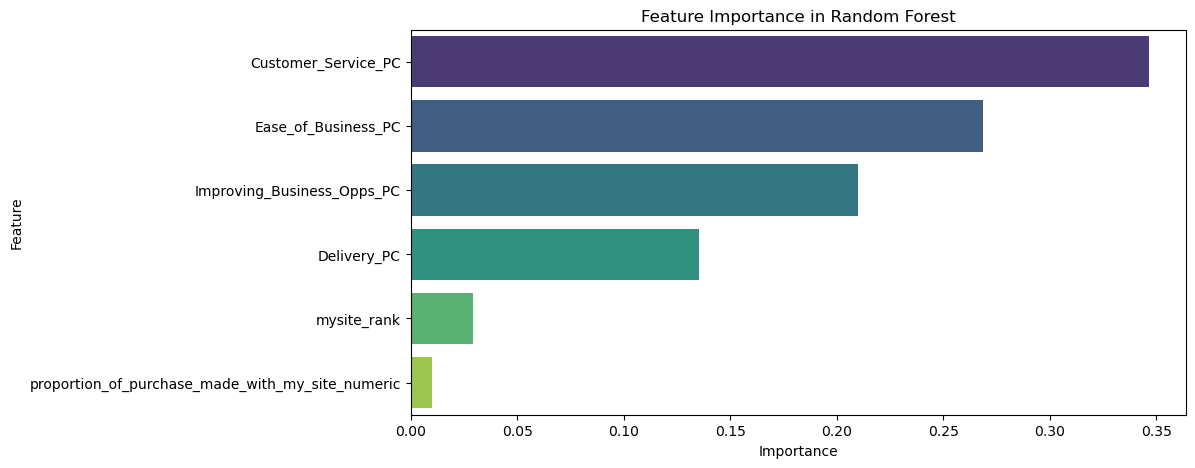

Results on Trainng Data :
Confusion Matrix:



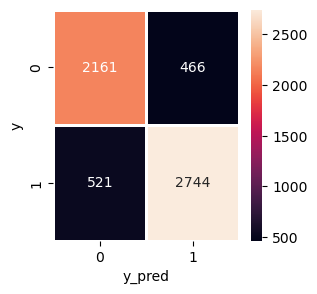

ROC Curve:



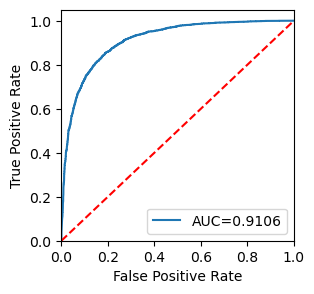

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2627
           1       0.85      0.84      0.85      3265

    accuracy                           0.83      5892
   macro avg       0.83      0.83      0.83      5892
weighted avg       0.83      0.83      0.83      5892

Precision Score for Positive Class : 0.8548
Recall Score for Positive Class: 0.8404
f1 Score for Positive Class: 0.8476
Accuracy Score for Positive Class: 0.8325
Results on Validation Data :
Confusion Matrix:



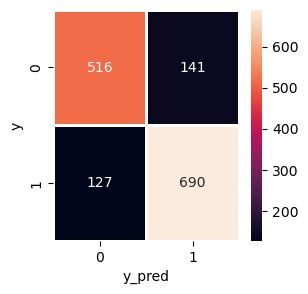

ROC Curve:



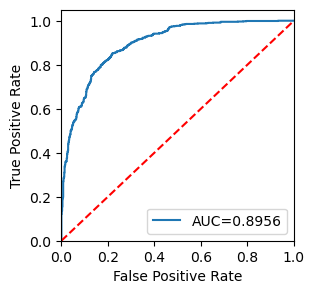

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       657
           1       0.83      0.84      0.84       817

    accuracy                           0.82      1474
   macro avg       0.82      0.81      0.82      1474
weighted avg       0.82      0.82      0.82      1474

Precision Score for Positive Class : 0.8303
Recall Score for Positive Class: 0.8446
f1 Score for Positive Class: 0.8374
Accuracy Score for Positive Class: 0.8182


In [28]:
# Initialize and Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=4,min_samples_leaf = 7, max_features = 'log2', max_depth = 5, bootstrap = True)
rf_model.fit(X_train, y_train)

# Feature Importance Visualization
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance in Random Forest")
plt.show()

cutoff = 0.55
y_pred_proba_train = rf_model.predict_proba(X_train)[:,1]
y_pred_train = np.where(y_pred_proba_train> cutoff,1,0)

print ('Results on Trainng Data :')
model_evaluation_report(y_train,y_pred_train,y_pred_proba_train)

y_pred_proba_test = rf_model.predict_proba(X_test)[:,1]
y_pred_test = np.where(y_pred_proba_test> cutoff,1,0)

print ('Results on Validation Data :')
model_evaluation_report(y_test,y_pred_test,y_pred_proba_test)

## XGB

In [29]:
# ##  Fine-tuning in the neighbourhood 

# max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# min_sample_leaf_nodes = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# est=[int(x) for x in np.linspace(start = 50, stop = 200, num = 15)]
# min_child_weight=[int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# colsample_bytree=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# subsample=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# gamma=[float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 9)]
# learning_rate=[float(x) for x in np.linspace(start = 0.01, stop = 0.09, num = 9)]




# param_grid = {'n_estimators':est,'max_depth': max_depth,
#     'max_leaves': min_sample_leaf_nodes,'min_child_weight':min_child_weight,'colsample_bytree':colsample_bytree,'subsample':subsample,'gamma':gamma,'learning_rate':learning_rate, 'objective' :['binary:logistic'],'importance_type' : ['gain']}
# print(param_grid)

# # Create a xgboost classifier
# xgb3 = XGBClassifier(random_state=4)

# # Use random search to find the best hyperparameters
# tree_random = RandomizedSearchCV(estimator = xgb3,param_distributions = param_grid,n_iter = 100,cv = 10,verbose = 1,random_state = 4,n_jobs = -1,scoring='accuracy')
# tree_random.fit(X_train, y_train)
# # Print the best hyperparameters
# print(tree_random.best_params_)
# print("Best Cross-Validation Score:", tree_random.best_score_)

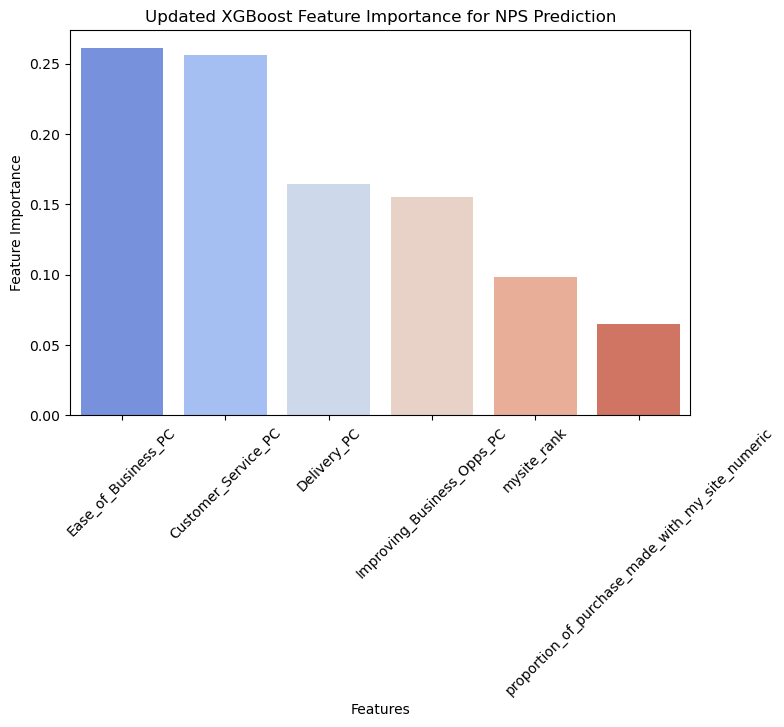

Results on Trainng Data :
Confusion Matrix:



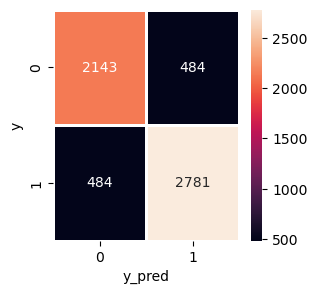

ROC Curve:



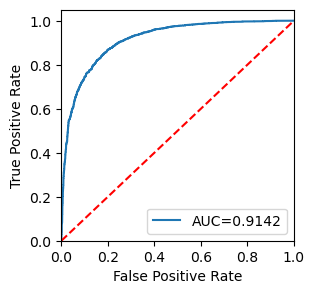

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2627
           1       0.85      0.85      0.85      3265

    accuracy                           0.84      5892
   macro avg       0.83      0.83      0.83      5892
weighted avg       0.84      0.84      0.84      5892

Precision Score for Positive Class : 0.8518
Recall Score for Positive Class: 0.8518
f1 Score for Positive Class: 0.8518
Accuracy Score for Positive Class: 0.8357
Results on Validation Data :
Confusion Matrix:



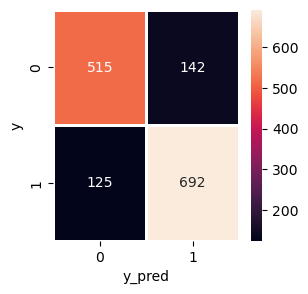

ROC Curve:



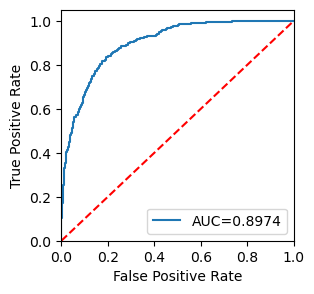

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       657
           1       0.83      0.85      0.84       817

    accuracy                           0.82      1474
   macro avg       0.82      0.82      0.82      1474
weighted avg       0.82      0.82      0.82      1474

Precision Score for Positive Class : 0.8297
Recall Score for Positive Class: 0.847
f1 Score for Positive Class: 0.8383
Accuracy Score for Positive Class: 0.8189


In [30]:
# Train an XGBoost model
xgb_model = XGBClassifier(random_state=4,subsample= 0.3,n_estimators= 120,min_child_weight= 6,
                         max_leaves= 15,max_depth= 10,learning_rate= 0.05,gamma= 0.5,colsample_bytree= 0.4,objective='binary:logistic')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Get feature importance from XGBoost model
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance_sorted.index, y=feature_importance_sorted.values, palette="coolwarm")
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Updated XGBoost Feature Importance for NPS Prediction")
plt.xticks(rotation=45)
plt.show()
cutoff = 0.55
y_pred_proba_train = xgb_model.predict_proba(X_train)[:,1]
y_pred_train = np.where(y_pred_proba_train> cutoff,1,0)

print ('Results on Trainng Data :')
model_evaluation_report(y_train,y_pred_train,y_pred_proba_train)

y_pred_proba_test = xgb_model.predict_proba(X_test)[:,1]
y_pred_test = np.where(y_pred_proba_test> cutoff,1,0)

print ('Results on Validation Data :')
model_evaluation_report(y_test,y_pred_test,y_pred_proba_test)

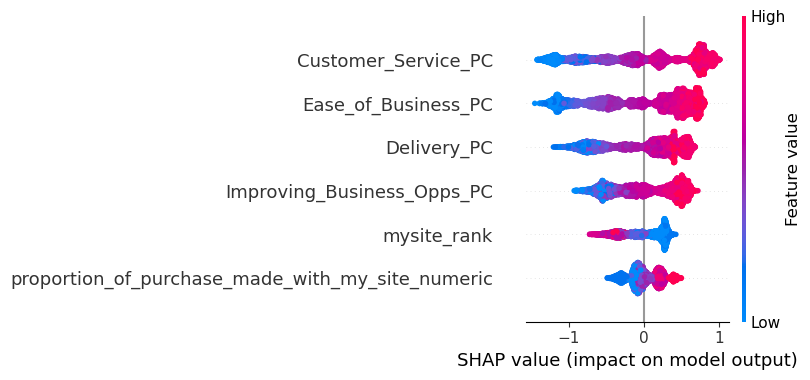

In [31]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [32]:
summary =  {'Evaluation_metrics':['Training_accuracy', 'Testing_accuracy', 'Precision','Specificity','Recall(Sensitivity)','f1-Score'],
        'Logistic':[accuracy_score(y_train,logisticRegr.predict(X_train_scaled)),accuracy_score(y_test_scaled,logisticRegr.predict(X_test_scaled)), precision_score(y_test_scaled,logisticRegr.predict(X_test_scaled)), recall_score(y_test_scaled,logisticRegr.predict(X_test_scaled),pos_label=0),recall_score(y_test_scaled,logisticRegr.predict(X_test_scaled)),f1_score(y_test_scaled,logisticRegr.predict(X_test_scaled))],
        'Random Forest':[accuracy_score(y_train,rf_model.predict(X_train)),accuracy_score(y_test,rf_model.predict(X_test)), precision_score(y_test,rf_model.predict(X_test)),recall_score(y_test,rf_model.predict(X_test),pos_label=0),recall_score(y_test,rf_model.predict(X_test)),f1_score(y_test,rf_model.predict(X_test))],
        'Xgb':[accuracy_score(y_train,xgb_model.predict(X_train)),accuracy_score(y_test,xgb_model.predict(X_test)), precision_score(y_test,xgb_model.predict(X_test)),recall_score(y_test,xgb_model.predict(X_test),pos_label=0) ,recall_score(y_test,xgb_model.predict(X_test)),f1_score(y_test,xgb_model.predict(X_test))]}

In [33]:
pd.DataFrame(summary).set_index('Evaluation_metrics')

Logistic  Random Forest       Xgb
Evaluation_metrics                                    
Training_accuracy    0.822980       0.831976  0.836558
Testing_accuracy     0.820217       0.812754  0.816825
Precision            0.809417       0.811995  0.814730
Specificity          0.741248       0.751903  0.754947
Recall(Sensitivity)  0.883721       0.861689  0.866585
f1-Score             0.844939       0.836105  0.839858